# Utility function

In [1]:
import os
import shutil

def copy_files(source_folder, destination_folder):
    try:
        if not os.path.exists(source_folder):
            raise FileNotFoundError(f"Source folder '{source_folder}' does not exist")

        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        for root, dirs, files in os.walk(source_folder):
            relative_path = os.path.relpath(root, source_folder)
            
            dest_dir = os.path.join(destination_folder, relative_path)
            if not os.path.exists(dest_dir):
                os.makedirs(dest_dir)
            
            for file_name in files:
                source_path = os.path.join(root, file_name)
                destination_path = os.path.join(dest_dir, file_name)
                
                shutil.copy2(source_path, destination_path)
                print(f"Copied: {os.path.join(relative_path, file_name)}")
            for dir_name in dirs:
                source_dir = os.path.join(root, dir_name)
                dest_subdir = os.path.join(dest_dir, dir_name)
                if not os.path.exists(dest_subdir):
                    os.makedirs(dest_subdir)
                    print(f"Created directory: {os.path.join(relative_path, dir_name)}")

        print(f"Successfully copied all contents from {source_folder} to {destination_folder}")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise 

In [2]:
import shutil
from pathlib import Path

def remove_directory_and_contents(directory_path, remove_subfolders=True):
    directory = Path(directory_path)
    if not directory.exists():
        raise FileNotFoundError(f"The directory {directory_path} does not exist")
    if not directory.is_dir() or directory.is_symlink():
        raise ValueError(f"The path {directory_path} is not a directory or is a symlink")
    
    if remove_subfolders:
        shutil.rmtree(directory)
    else:
        for item in directory.iterdir():
            if item.is_file():
                item.unlink() 

# Move to dataset to current working directory

In [3]:
# Create directories
os.makedirs("dataset", exist_ok=True)

In [4]:
copy_files(
    "/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images", 
    "/kaggle/working/dataset/images"
)
copy_files(
    "/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/masks", 
    "/kaggle/working/dataset/masks"
)

Copied: ./623.jpg
Copied: ./764.jpg
Copied: ./771.jpg
Copied: ./208.jpg
Copied: ./029.jpg
Copied: ./820.jpg
Copied: ./473.jpg
Copied: ./014.jpg
Copied: ./537.jpg
Copied: ./369.jpg
Copied: ./654.jpg
Copied: ./275.jpg
Copied: ./785.jpg
Copied: ./239.jpg
Copied: ./792.jpg
Copied: ./034.jpg
Copied: ./149.jpg
Copied: ./521.jpg
Copied: ./436.jpg
Copied: ./355.jpg
Copied: ./516.jpg
Copied: ./708.jpg
Copied: ./474.jpg
Copied: ./501.jpg
Copied: ./915.jpg
Copied: ./815.jpg
Copied: ./760.jpg
Copied: ./342.jpg
Copied: ./817.jpg
Copied: ./429.jpg
Copied: ./024.jpg
Copied: ./033.jpg
Copied: ./646.jpg
Copied: ./682.jpg
Copied: ./377.jpg
Copied: ./272.jpg
Copied: ./795.jpg
Copied: ./270.jpg
Copied: ./182.jpg
Copied: ./215.jpg
Copied: ./489.jpg
Copied: ./576.jpg
Copied: ./094.jpg
Copied: ./613.jpg
Copied: ./049.jpg
Copied: ./048.jpg
Copied: ./153.jpg
Copied: ./703.jpg
Copied: ./189.jpg
Copied: ./143.jpg
Copied: ./476.jpg
Copied: ./327.jpg
Copied: ./253.jpg
Copied: ./343.jpg
Copied: ./115.jpg
Copied: ./

In [5]:
copy_files(
    "/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/val/images", 
    "/kaggle/working/test"
)

Copied: ./333.jpg
Copied: ./212.jpg
Copied: ./150.jpg
Copied: ./109.jpg
Copied: ./187.jpg
Copied: ./539.jpg
Copied: ./544.jpg
Copied: ./185.jpg
Copied: ./930.jpg
Copied: ./243.jpg
Copied: ./717.jpg
Copied: ./824.jpg
Copied: ./062.jpg
Copied: ./892.jpg
Copied: ./622.jpg
Copied: ./273.jpg
Copied: ./286.jpg
Copied: ./950.jpg
Copied: ./361.jpg
Copied: ./806.jpg
Copied: ./163.jpg
Copied: ./211.jpg
Copied: ./949.jpg
Copied: ./704.jpg
Copied: ./818.jpg
Copied: ./271.jpg
Copied: ./951.jpg
Copied: ./011.jpg
Copied: ./629.jpg
Copied: ./089.jpg
Copied: ./441.jpg
Copied: ./924.jpg
Copied: ./427.jpg
Copied: ./313.jpg
Copied: ./375.jpg
Copied: ./396.jpg
Copied: ./123.jpg
Copied: ./872.jpg
Copied: ./167.jpg
Copied: ./012.jpg
Copied: ./938.jpg
Copied: ./478.jpg
Copied: ./374.jpg
Copied: ./152.jpg
Copied: ./192.jpg
Copied: ./051.jpg
Copied: ./651.jpg
Copied: ./832.jpg
Copied: ./018.jpg
Copied: ./358.jpg
Copied: ./943.jpg
Copied: ./928.jpg
Copied: ./864.jpg
Copied: ./314.jpg
Copied: ./826.jpg
Copied: ./

# Split the dataset

In [6]:
import os
import shutil
import random
import cv2
import numpy as np
from collections import defaultdict

def split_image_mask_dataset(image_folder, mask_folder, output_folder, train_ratio=0.8):
    if not os.path.exists(image_folder):
        raise ValueError(f"Image folder '{image_folder}' does not exist")
    if not os.path.exists(mask_folder):
        raise ValueError(f"Mask folder '{mask_folder}' does not exist")
    if not 0 < train_ratio < 1:
        raise ValueError(f"train_ratio must be between 0 and 1, got {train_ratio}")

    train_dir = os.path.join(output_folder, 'train')
    val_dir = os.path.join(output_folder, 'val')
    train_images_dir = os.path.join(train_dir, 'images')
    train_masks_dir = os.path.join(train_dir, 'masks')
    val_images_dir = os.path.join(val_dir, 'images')
    val_masks_dir = os.path.join(val_dir, 'masks')

    for dir_path in [train_images_dir, train_masks_dir, val_images_dir, val_masks_dir]:
        os.makedirs(dir_path, exist_ok=True)

    image_files = []
    fragment_counts = defaultdict(list)

    for f in os.listdir(image_folder):
        if f.endswith('.jpg'):
            mask_file = f.replace('.jpg', '.png')
            mask_path = os.path.join(mask_folder, mask_file)
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    print(f"Warning: Could not load mask {mask_file}, skipping {f}")
                    continue
                
                unique_values = np.unique(mask)
                unique_values = unique_values[unique_values > 0]
                num_fragments = len(unique_values)

                image_files.append(f)
                fragment_counts[num_fragments].append(f)
            else:
                print(f"Warning: Skipping {f} - mask file {mask_file} not found in mask folder")

    if not image_files:
        raise ValueError("No valid image-mask pairs found")

    train_files = []
    val_files = []

    for num_fragments, files in fragment_counts.items():
        random.shuffle(files)
        train_count = int(len(files) * train_ratio)
        train_files.extend(files[:train_count])
        val_files.extend(files[train_count:])

    random.shuffle(train_files)
    random.shuffle(val_files)

    def copy_file_pair(img_file, src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir):
        mask_file = img_file.replace('.jpg', '.png')
        src_img = os.path.join(src_img_dir, img_file)
        src_mask = os.path.join(src_mask_dir, mask_file)
        dst_img = os.path.join(dst_img_dir, img_file)
        dst_mask = os.path.join(dst_mask_dir, mask_file)
        try:
            shutil.copy2(src_img, dst_img)
            shutil.copy2(src_mask, dst_mask)
            return True
        except Exception as e:
            print(f"Error copying {img_file} or {mask_file}: {str(e)}")
            return False

    train_success = 0
    for img_file in train_files:
        if copy_file_pair(img_file, image_folder, mask_folder, train_images_dir, train_masks_dir):
            train_success += 1
            print(f"Copied {img_file} and its mask to training set")

    val_success = 0
    for img_file in val_files:
        if copy_file_pair(img_file, image_folder, mask_folder, val_images_dir, val_masks_dir):
            val_success += 1
            print(f"Copied {img_file} and its mask to validation set")

    print(f"\nDataset split complete (stratified by fragment distribution):")
    print(f"Total valid image-mask pairs found: {len(image_files)}")
    print(f"Training set: {train_success} pairs ({train_success/len(image_files)*100:.1f}%)")
    print(f"Validation set: {val_success} pairs ({val_success/len(image_files)*100:.1f}%)")

    train_frag_dist = defaultdict(int)
    val_frag_dist = defaultdict(int)
    for f in train_files:
        mask_file = f.replace('.jpg', '.png')
        mask = cv2.imread(os.path.join(mask_folder, mask_file), cv2.IMREAD_GRAYSCALE)
        num_fragments = len(np.unique(mask)[np.unique(mask) > 0])
        train_frag_dist[num_fragments] += 1
    for f in val_files:
        mask_file = f.replace('.jpg', '.png')
        mask = cv2.imread(os.path.join(mask_folder, mask_file), cv2.IMREAD_GRAYSCALE)
        num_fragments = len(np.unique(mask)[np.unique(mask) > 0])
        val_frag_dist[num_fragments] += 1

    print("\nFragment distribution:")
    print("Training set:", dict(train_frag_dist))
    print("Validation set:", dict(val_frag_dist))

In [7]:
split_image_mask_dataset(
    '/kaggle/working/dataset/images', 
    '/kaggle/working/dataset/masks', 
    '/kaggle/working/', 
    train_ratio=0.8
)

Copied 398.jpg and its mask to training set
Copied 760.jpg and its mask to training set
Copied 788.jpg and its mask to training set
Copied 771.jpg and its mask to training set
Copied 463.jpg and its mask to training set
Copied 833.jpg and its mask to training set
Copied 328.jpg and its mask to training set
Copied 056.jpg and its mask to training set
Copied 755.jpg and its mask to training set
Copied 696.jpg and its mask to training set
Copied 394.jpg and its mask to training set
Copied 093.jpg and its mask to training set
Copied 446.jpg and its mask to training set
Copied 284.jpg and its mask to training set
Copied 854.jpg and its mask to training set
Copied 005.jpg and its mask to training set
Copied 886.jpg and its mask to training set
Copied 664.jpg and its mask to training set
Copied 254.jpg and its mask to training set
Copied 526.jpg and its mask to training set
Copied 656.jpg and its mask to training set
Copied 506.jpg and its mask to training set
Copied 952.jpg and its mask to t

In [8]:
remove_directory_and_contents("/kaggle/working/dataset")

# Convert mask to YOLO segmentation format

In [9]:
import cv2
import numpy as np
import os
from pathlib import Path

def convert_mask_to_yolo(mask_path, output_label_path, image_shape, class_id=1):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Could not load mask at {mask_path}")

    if mask.shape != image_shape:
        mask = cv2.resize(mask, (image_shape[1], image_shape[0]), interpolation=cv2.INTER_NEAREST)

    unique_values = np.unique(mask)
    unique_values = unique_values[unique_values > 0]

    if len(unique_values) == 0:
        return s

    height, width = image_shape
    with open(output_label_path, 'w') as f:
        for value in unique_values:
            instance_mask = (mask == value).astype(np.uint8) * 255
            
            contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                continue

            for contour in contours:
                contour = contour.reshape(-1, 2)
                points = contour / [width, height]
                points_str = " ".join(map(str, points.flatten()))
                f.write(f"{class_id} {points_str}\n")

    if os.stat(output_label_path).st_size == 0:
        os.remove(output_label_path)

In [10]:
def process_dataset(image_dir, mask_dir, label_dir):
    os.makedirs(label_dir, exist_ok=True)
    
    for img_file in os.listdir(image_dir):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(image_dir, img_file)
            mask_file = img_file.replace('.jpg', '.png')
            mask_path = os.path.join(mask_dir, mask_file)
            label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))
            
            if os.path.exists(mask_path):
                img = cv2.imread(img_path)
                if img is not None:
                    convert_mask_to_yolo(mask_path, label_path, img.shape[:2])

In [11]:
# Convert masks to labels
process_dataset(
    "/kaggle/working/train/images", 
    "/kaggle/working/train/masks", 
    "/kaggle/working/train/labels"
)
process_dataset(
    "/kaggle/working/val/images", 
    "/kaggle/working/val/masks", 
    "/kaggle/working/val/labels"
)

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_yolo_segmentation(image_path, label_path, output_image_path=None):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    contours = []
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 3: 
                    continue
                class_id = int(parts[0]) 
                coords = np.array(parts[1:], dtype=np.float32).reshape(-1, 2) 
                coords[:, 0] *= width 
                coords[:, 1] *= height
                contours.append(coords.astype(np.int32))
    except FileNotFoundError:
        raise ValueError(f"Could not find label file at {label_path}")

    if not contours:
        print("No valid contours found in the label file.")
        return

    overlay_image = image.copy()
    cv2.polylines(overlay_image, contours, isClosed=True, color=(255, 0, 0), thickness=2)
    plt.figure(figsize=(8, 6))
    plt.title("Image with YOLO Segmentation Overlay")
    plt.imshow(overlay_image)
    plt.axis('off')
    plt.show()
    if output_image_path:
        cv2.imwrite(output_image_path, cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR))
        print(f"Overlay image saved at: {output_image_path}")

In [13]:
def random_visualize_yolo_segmentation(image_dir, label_dir, output_image_path=None):
    if not os.path.exists(image_dir):
        raise ValueError(f"Image directory '{image_dir}' does not exist")
    if not os.path.exists(label_dir):
        raise ValueError(f"Label directory '{label_dir}' does not exist")

    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError(f"No .jpg images found in {image_dir}")

    random_image_file = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image_file)
    label_file = random_image_file.replace('.jpg', '.txt')
    label_path = os.path.join(label_dir, label_file)

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Label file '{label_file}' not found for image '{random_image_file}'")

    visualize_yolo_segmentation(image_path, label_path, output_image_path)

    print(f"Displayed: {random_image_file} with annotations from {label_file}")

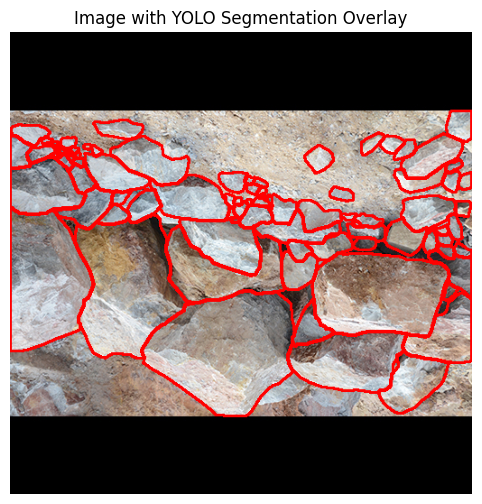

Displayed: 515.jpg with annotations from 515.txt


In [14]:
random_visualize_yolo_segmentation(
    image_dir="/kaggle/working/train/images",
    label_dir="/kaggle/working/train/labels"
)

# Create YAML file

In [15]:
import yaml
import os

def create_yolov8_yaml(
    data_dir, train_images_path, val_images_path, output_yaml_path, num_classes, class_names):

    if not os.path.exists(train_images_path):
        raise FileNotFoundError(f"Training images directory not found: {train_images_path}")
    if not os.path.exists(val_images_path):
        raise FileNotFoundError(f"Validation images directory not found: {val_images_path}")
    yaml_data = {
        "path": data_dir,              
        "train": train_images_path, 
        "val": val_images_path,  
        "nc": num_classes,      
        "names": class_names  
    }
    with open(output_yaml_path, "w") as f:
        yaml.dump(yaml_data, f, default_flow_style=False)

    print(f"YAML file created at: {output_yaml_path}")

In [16]:
create_yolov8_yaml(
    data_dir="/kaggle/working",
    train_images_path="train/images",
    val_images_path="val/images",
    output_yaml_path="/kaggle/working/dataset.yaml",
    num_classes=2,
    class_names=["background", "rock fragment"]
)

YAML file created at: /kaggle/working/dataset.yaml


# Hyperparameter tuning YOLOv11m-seg

In [17]:
!pip install ultralytics
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 40.5 MB/s eta 0:00:00


In [18]:
import numpy as np
import cv2

def iou_score(true_mask, pred_mask):
    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = np.logical_or(true_mask, pred_mask).sum()
    return intersection / union if union > 0 else 0

In [19]:
import optuna
from ultralytics import YOLO
import os
import numpy as np
import cv2

def objective(trial):
    # Hyperparameter search space
    # Learning-related parameters
    lr0 = trial.suggest_float("lr0", 1e-4, 1e-2, log=True)  # Initial learning rate
    lrf = trial.suggest_float("lrf", 1e-3, 1e-1, log=True)  # Final learning rate factor
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "AdamW", "Adam"])  # Optimizer
    # Augmentation parameters
    hsv_h = trial.suggest_float("hsv_h", 0.0, 0.05)  # Hue augmentation (small range due to color sensitivity)
    hsv_s = trial.suggest_float("hsv_s", 0.1, 0.7)   # Saturation augmentation
    hsv_v = trial.suggest_float("hsv_v", 0.1, 0.5)   # Value (brightness) augmentation
    degrees = trial.suggest_float("degrees", 0.0, 10.0)  # Rotation augmentation
    # translate = trial.suggest_float("translate", 0.0, 0.2)  # Translation augmentation
    scale = trial.suggest_float("scale", 0.1, 0.5)   # Scaling augmentation
    shear = trial.suggest_float("shear", 0.0, 5.0)   # Shear augmentation
    fliplr = trial.suggest_float("fliplr", 0.0, 0.5)  # Horizontal flip probability
    flipud = trial.suggest_float("flipud", 0.0, 0.5)  # Vertical flip probability
    mosaic = trial.suggest_float("mosaic", 0.5, 1.0)  # Mosaic augmentation probability
    mixup = trial.suggest_float("mixup", 0.0, 0.5)    # Mixup augmentation probability

    # Load and train the model
    model = YOLO("yolo11m-seg.pt")
    model.train(
        data="/kaggle/working/dataset.yaml",
        epochs=5,
        imgsz=1024,
        batch=2,
        device=0,
        patience=10,
        pretrained=True,
        optimizer=optimizer,
        lr0=lr0,
        lrf=lrf,
        cos_lr=True,
        augment=True,
        hsv_h=hsv_h,
        hsv_s=hsv_s,
        hsv_v=hsv_v,
        degrees=degrees,
        # translate=translate,
        translate = 0.1,
        # scale=scale,
        scale=0.3,
        shear=shear,
        fliplr=fliplr,
        flipud=flipud,
        mosaic=mosaic,
        mixup=mixup,
        project="/kaggle/working/runs/tune",
        name=f"trial_{trial.number}"
    )

    # Compute mIoU on validation set
    val_image_dir = "/kaggle/working/val/images"
    val_mask_dir = "/kaggle/working/val/masks"
    iou_scores = []

    for img_file in os.listdir(val_image_dir):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(val_image_dir, img_file)
            mask_file = img_file.replace('.jpg', '.png')
            true_mask_path = os.path.join(val_mask_dir, mask_file)

            true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
            if true_mask is None:
                continue
            true_mask = (true_mask > 0).astype(np.uint8)

            results = model.predict(img_path, conf=0.5, iou=0.5, save=False)
            result = results[0]

            if result.masks is not None:
                masks = result.masks.data.cpu().numpy()
                if masks.shape[1:] != true_mask.shape:
                    masks_resized = [cv2.resize(mask, (true_mask.shape[1], true_mask.shape[0]), 
                                              interpolation=cv2.INTER_NEAREST) for mask in masks]
                    masks = np.array(masks_resized)
                pred_mask = np.max(masks, axis=0)
                pred_mask = (pred_mask > 0.5).astype(np.uint8)
            else:
                pred_mask = np.zeros_like(true_mask)

            iou = iou_score(true_mask, pred_mask)
            iou_scores.append(iou)

    mIoU = np.mean(iou_scores) if iou_scores else 0.0
    return mIoU

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [20]:
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=45)

[I 2025-04-05 17:59:26,907] A new study created in memory with name: no-name-56add2e3-2d16-4b80-89d1-38004656675d


100%|██████████| 43.3M/43.3M [00:00<00:00, 48.5MB/s]


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_0, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 103MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 357MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/train/labels... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:02<00:00, 238.20it/s]


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/val/labels... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:01<00:00, 128.46it/s]


val: New cache created: /kaggle/working/val/labels.cache
Plotting labels to /kaggle/working/runs/tune/trial_0/labels.jpg... 
optimizer: Adam(lr=0.0094338579969315, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_0
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.96G       1.64      3.393      1.579      1.612         92       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.92it/s]


                   all        177      11844      0.452      0.497      0.411      0.198      0.399      0.369      0.302      0.109

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.97G      1.603      3.241      1.485      1.605         75       1024: 100%|██████████| 296/296 [02:29<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.78it/s]

                   all        177      11844      0.211      0.227      0.137     0.0742      0.182      0.181     0.0967     0.0434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.97G      1.517      2.998      1.365      1.534         70       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.97it/s]

                   all        177      11844      0.646      0.605      0.637      0.372      0.638       0.59      0.616      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.97G        1.4      2.763      1.232      1.465         64       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.714      0.651      0.722       0.46      0.705      0.644      0.706      0.392



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.97G       1.31      2.553      1.189      1.395         63       1024: 100%|██████████| 296/296 [02:28<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.731       0.68       0.74      0.498      0.731      0.677      0.736      0.446



5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_0/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_0/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_0/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:19,  2.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:29,  1.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:42,  1.05s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:38,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:41,  1.07s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:35,  1.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:06<00:30,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:26,  1.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:22,  1.58it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:18,  1.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:08<00:11,  2.66it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:09,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:11<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:14<00:03,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:15<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:17<00:00,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


                   all        177      11844       0.73       0.68       0.74      0.498       0.73      0.677      0.736      0.446
         rock fragment        177      11844       0.73       0.68       0.74      0.498       0.73      0.677      0.736      0.446


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.4ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_0

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 39 rock fragments, 45.4ms
Speed: 5.1ms preprocess, 45.4ms inference, 14.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 15 rock fragments, 45.2ms
Speed: 5.0ms preprocess, 45.2ms inference, 3.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 57 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 18:15:09,408] Trial 0 finished with value: 0.6644759602643531 and parameters: {'lr0': 0.0094338579969315, 'lrf': 0.003642034959112253, 'optimizer': 'Adam', 'hsv_h': 0.023517280016676252, 'hsv_s': 0.32169340480452324, 'hsv_v': 0.4633581582969468, 'degrees': 8.097325901884242, 'scale': 0.4740464194609918, 'shear': 4.1471102628002985, 'fliplr': 0.4913621326628977, 'flipud': 0.2924485983807927, 'mosaic': 0.8238174011184008, 'mixup': 0.10026637875652755}. Best is trial 0 with value: 0.6644759602643531.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_1, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_1/labels.jpg... 
optimizer: AdamW(lr=0.0019760084760944894, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_1
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      14.5G      1.451      3.044      1.389      1.457         40       1024: 100%|██████████| 296/296 [02:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.99it/s]

                   all        177      11844      0.703      0.653      0.705      0.453      0.618      0.526      0.522      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      12.1G      1.427      2.898      1.262      1.461         79       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.726      0.689      0.735      0.486      0.709      0.675      0.708      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.46G      1.357      2.741      1.173       1.42         74       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.724      0.709      0.759      0.515      0.718      0.708      0.753       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.31G      1.315      2.618      1.119      1.385        159       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.754      0.721      0.787      0.558      0.752       0.72      0.783      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.31G      1.251      2.516      1.049      1.348        112       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.14it/s]

                   all        177      11844      0.771      0.749      0.811      0.589      0.772      0.747      0.811      0.537



5 epochs completed in 0.235 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_1/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_1/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_1/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:20,  2.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:30,  1.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:39,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:38,  1.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:04<00:34,  1.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:05<00:35,  1.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:06<00:28,  1.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:06<00:24,  1.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:22,  1.58it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:07<00:18,  1.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:08<00:11,  2.69it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:08<00:10,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:09<00:08,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:07,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:10<00:07,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:10<00:06,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:11<00:06,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:11<00:05,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:12<00:05,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:13<00:04,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:13<00:03,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:14<00:03,  3.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:14<00:02,  3.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:15<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:15<00:02,  3.45it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:16<00:01,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:16<00:00,  3.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:17<00:00,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.56it/s]


                   all        177      11844      0.771      0.749      0.811      0.589      0.772      0.747      0.811      0.537
         rock fragment        177      11844      0.771      0.749      0.811      0.589      0.772      0.747      0.811      0.537


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.8ms preprocess, 54.1ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_1

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 44 rock fragments, 45.3ms
Speed: 5.1ms preprocess, 45.3ms inference, 5.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 18 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 57 rock fragments, 45.2ms
Speed: 11.9ms preprocess, 45.2ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 18:30:40,426] Trial 1 finished with value: 0.7921112499216618 and parameters: {'lr0': 0.0019760084760944894, 'lrf': 0.07692011209543795, 'optimizer': 'AdamW', 'hsv_h': 0.010889529364552992, 'hsv_s': 0.19816168637961307, 'hsv_v': 0.33624527681468686, 'degrees': 7.365679681409164, 'scale': 0.2026400226610504, 'shear': 2.3166072126743087, 'fliplr': 0.12152696502043242, 'flipud': 0.2526832471825939, 'mosaic': 0.7324963023745648, 'mixup': 0.36971236903799076}. Best is trial 1 with value: 0.7921112499216618.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_2, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_2/labels.jpg... 
optimizer: SGD(lr=0.0005536771106063402, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      14.7G      1.669       3.58      2.608      1.747        104       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.69it/s]

                   all        177      11844      0.563      0.538      0.557      0.355      0.557      0.533      0.545      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.94G      1.453      3.067      1.512      1.537        122       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.87it/s]

                   all        177      11844      0.665       0.64      0.675      0.455      0.657      0.634      0.663      0.382



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      13.1G      1.381      2.892      1.332      1.466        179       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.88it/s]

                   all        177      11844      0.697      0.683       0.73      0.505      0.698      0.679      0.721      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.03G      1.319      2.715      1.232      1.406         86       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.89it/s]

                   all        177      11844      0.729      0.698      0.755       0.53      0.727      0.689      0.746      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.97G      1.288      2.661      1.196      1.392        188       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.91it/s]

                   all        177      11844      0.731      0.703      0.759      0.537      0.733      0.697      0.754      0.461



5 epochs completed in 0.236 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_2/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_2/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_2/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.79it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:20,  2.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:32,  1.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:42,  1.03s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:38,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:40,  1.03s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:35,  1.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:06<00:29,  1.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:23,  1.53it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:19,  1.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:07<00:16,  2.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:12,  2.50it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:08<00:11,  2.67it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.83it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:09,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:09<00:09,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:08,  2.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:08,  2.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:07,  3.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:06,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  2.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  2.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:04,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:03,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.43it/s]


                   all        177      11844       0.73      0.705       0.76      0.537      0.732      0.698      0.754      0.461
         rock fragment        177      11844       0.73      0.705       0.76      0.537      0.732      0.698      0.754      0.461


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 54.1ms inference, 0.0ms loss, 13.4ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_2

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 48 rock fragments, 45.3ms
Speed: 5.0ms preprocess, 45.3ms inference, 5.7ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 18 rock fragments, 45.2ms
Speed: 4.9ms preprocess, 45.2ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 59 rock fragments, 45.2ms
Speed: 4.8ms preprocess, 45.2ms inference, 6.7ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 18:46:12,166] Trial 2 finished with value: 0.7693590208538434 and parameters: {'lr0': 0.0005536771106063402, 'lrf': 0.01093024173403867, 'optimizer': 'SGD', 'hsv_h': 0.042606890239868356, 'hsv_s': 0.10045784897651788, 'hsv_v': 0.28484757431165, 'degrees': 3.411014911359377, 'scale': 0.29347898428388164, 'shear': 4.83856703923777, 'fliplr': 0.2678872423090188, 'flipud': 0.4929631678294361, 'mosaic': 0.6844605394951186, 'mixup': 0.3173907700006895}. Best is trial 1 with value: 0.7921112499216618.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_3/labels.jpg... 
optimizer: Adam(lr=0.003547997026800749, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.13G      1.531      3.217      1.474       1.52         77       1024: 100%|██████████| 296/296 [02:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.72it/s]

                   all        177      11844      0.159      0.472      0.129     0.0816      0.126      0.377     0.0932     0.0385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.68G      1.519      3.094      1.365      1.538        137       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.99it/s]

                   all        177      11844      0.612       0.65      0.632      0.382      0.616      0.633      0.621      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      14.6G      1.468      2.928      1.282      1.505        195       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.728      0.667      0.724      0.462      0.725      0.662      0.714        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      15.2G      1.387       2.74      1.189      1.449         56       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.758      0.706      0.777      0.536      0.759      0.707      0.777      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.5G      1.325       2.59      1.103      1.403         87       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.766      0.734        0.8      0.566      0.767      0.732      0.799       0.51



5 epochs completed in 0.236 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_3/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_3/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_3/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:19,  2.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:30,  1.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:45,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:40,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:43,  1.12s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:37,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:06<00:29,  1.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:24,  1.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:20,  1.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:07<00:16,  2.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:12,  2.54it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:08<00:11,  2.75it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:09,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:11<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:04,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:14<00:03,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:15<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:16<00:01,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:17<00:00,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.50it/s]


                   all        177      11844      0.766      0.734      0.801      0.566      0.768      0.731      0.799       0.51
         rock fragment        177      11844      0.766      0.734      0.801      0.566      0.768      0.731      0.799       0.51


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 53.4ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_3

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 48 rock fragments, 45.3ms
Speed: 5.4ms preprocess, 45.3ms inference, 6.7ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 19 rock fragments, 45.2ms
Speed: 5.0ms preprocess, 45.2ms inference, 3.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 65 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rever

[I 2025-04-05 19:01:48,385] Trial 3 finished with value: 0.7734101693422841 and parameters: {'lr0': 0.003547997026800749, 'lrf': 0.0032129218355408046, 'optimizer': 'Adam', 'hsv_h': 0.04547360779013985, 'hsv_s': 0.5874387934081149, 'hsv_v': 0.24459708003924804, 'degrees': 4.327063941423611, 'scale': 0.1077387821867307, 'shear': 4.7998348862422375, 'fliplr': 0.34047149372284136, 'flipud': 0.32550026601802123, 'mosaic': 0.894499281647888, 'mixup': 0.33453796141094405}. Best is trial 1 with value: 0.7921112499216618.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_4, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_4/labels.jpg... 
optimizer: SGD(lr=0.0027261141058969097, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.56G      1.451       3.09      1.897      1.551         54       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.84it/s]

                   all        177      11844      0.657      0.609      0.654      0.434      0.646      0.596      0.627      0.346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      12.7G      1.261      2.586      1.167      1.366         73       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  3.00it/s]

                   all        177      11844      0.757      0.695      0.776      0.568      0.759      0.692      0.773      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.55G      1.193      2.384      1.066      1.296         97       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.03it/s]

                   all        177      11844      0.761       0.73      0.794       0.58      0.763      0.727      0.792      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.55G      1.158      2.294      0.984      1.271        136       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.783      0.756       0.82       0.61      0.785      0.755      0.821      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      14.2G      1.162      2.319     0.9752      1.275         78       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.794      0.769      0.834      0.622      0.793      0.768      0.833      0.568



5 epochs completed in 0.235 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_4/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_4/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_4/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:19,  2.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:29,  1.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:41,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:36,  1.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:41,  1.06s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:35,  1.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:06<00:29,  1.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:06<00:23,  1.53it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:19,  1.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:07<00:16,  2.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:07<00:14,  2.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:12,  2.55it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:08<00:11,  2.76it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:08<00:10,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:09,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:09<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:08,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:10<00:07,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:11<00:06,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:11<00:06,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:12<00:05,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:13<00:04,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:14<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:14<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:15<00:02,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:15<00:02,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:16<00:01,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:17<00:00,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.52it/s]


                   all        177      11844      0.794      0.768      0.834      0.622      0.793      0.768      0.833      0.568
         rock fragment        177      11844      0.794      0.768      0.834      0.622      0.793      0.768      0.833      0.568


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 54.0ms inference, 0.2ms loss, 7.2ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_4

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 60 rock fragments, 45.3ms
Speed: 5.0ms preprocess, 45.3ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 28 rock fragments, 45.1ms
Speed: 4.9ms preprocess, 45.1ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 74 rock fragments, 45.2ms
Speed: 4.9ms preprocess, 45.2ms inference, 8.6ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rever

[I 2025-04-05 19:17:24,962] Trial 4 finished with value: 0.8385130544633549 and parameters: {'lr0': 0.0027261141058969097, 'lrf': 0.09426203494961997, 'optimizer': 'SGD', 'hsv_h': 0.024710869230567402, 'hsv_s': 0.29025805374853136, 'hsv_v': 0.1969825382076249, 'degrees': 0.7786416108789584, 'scale': 0.19322227746837506, 'shear': 4.51456213926652, 'fliplr': 0.31261467660577436, 'flipud': 0.04627364141617574, 'mosaic': 0.8741275984572141, 'mixup': 0.2944754028003541}. Best is trial 4 with value: 0.8385130544633549.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_5, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_5/labels.jpg... 
optimizer: Adam(lr=0.00036691059284512675, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_5
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      13.3G      1.353      2.836      1.309      1.385         54       1024: 100%|██████████| 296/296 [02:33<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.707      0.684      0.734      0.505      0.666       0.65      0.648      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      13.3G      1.247      2.506      1.143      1.306         82       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.743      0.723      0.771      0.554      0.735      0.716       0.76       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      13.3G      1.198      2.346       1.02      1.278         53       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844       0.79      0.749       0.82       0.59      0.793      0.747      0.818       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      13.3G      1.161      2.263     0.9725       1.26        129       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844       0.79       0.77      0.831      0.616      0.795      0.772      0.831      0.562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      13.3G      1.143      2.283     0.9423      1.255        127       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.805      0.775      0.841      0.628      0.805      0.775       0.84      0.576



5 epochs completed in 0.235 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_5/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_5/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_5/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:21,  2.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:30,  1.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:43,  1.07s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:38,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:40,  1.03s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:34,  1.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:06<00:30,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:25,  1.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:21,  1.63it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:07<00:17,  1.89it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.45it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:08<00:11,  2.70it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:09,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:10<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:11<00:06,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:13<00:04,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:14<00:03,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:15<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:16<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:17<00:00,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.51it/s]


                   all        177      11844      0.803      0.777      0.841      0.627      0.802      0.779       0.84      0.576
         rock fragment        177      11844      0.803      0.777      0.841      0.627      0.802      0.779       0.84      0.576


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.8ms preprocess, 53.7ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_5

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 57 rock fragments, 45.8ms
Speed: 5.3ms preprocess, 45.8ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 28 rock fragments, 45.1ms
Speed: 4.9ms preprocess, 45.1ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 83 rock fragments, 45.6ms
Speed: 5.1ms preprocess, 45.6ms inference, 9.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rever

[I 2025-04-05 19:33:04,659] Trial 5 finished with value: 0.8537978080455271 and parameters: {'lr0': 0.00036691059284512675, 'lrf': 0.006090672078695112, 'optimizer': 'Adam', 'hsv_h': 0.009387904697285732, 'hsv_s': 0.5061616849977899, 'hsv_v': 0.1822716309137106, 'degrees': 5.905079689372032, 'scale': 0.18142048291728663, 'shear': 3.4739800095192623, 'fliplr': 0.4869670009734647, 'flipud': 0.05206516354939378, 'mosaic': 0.8462235041890503, 'mixup': 0.3032054908247697}. Best is trial 5 with value: 0.8537978080455271.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_6, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_6/labels.jpg... 
optimizer: SGD(lr=0.0023092466319876463, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.87G      1.372       2.94      1.928      1.485         87       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.89it/s]

                   all        177      11844      0.682      0.642      0.689      0.467      0.677      0.637      0.676      0.389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.9G      1.187      2.391      1.124      1.307         40       1024: 100%|██████████| 296/296 [02:27<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.01it/s]

                   all        177      11844      0.752      0.681       0.76      0.548      0.751      0.679      0.757      0.483



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.9G       1.11      2.167      1.002      1.235         70       1024: 100%|██████████| 296/296 [02:28<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.01it/s]

                   all        177      11844      0.756      0.713      0.786      0.565      0.757      0.705      0.781      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.9G      1.062      2.046     0.9025      1.196         89       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.779      0.749      0.817      0.599       0.78      0.745      0.816      0.545



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.9G      1.072      2.077     0.8937      1.204         59       1024: 100%|██████████| 296/296 [02:27<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.784      0.757      0.825      0.605      0.787      0.754      0.823      0.551



5 epochs completed in 0.230 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_6/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_6/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_6/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.79it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:24,  1.75it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:45,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:39,  1.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:45,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:36,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:30,  1.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:24,  1.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:21,  1.66it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.89it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.61it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.80it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:04,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:03,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.43it/s]


                   all        177      11844      0.783      0.757      0.825      0.605      0.783      0.756      0.823      0.551
         rock fragment        177      11844      0.783      0.757      0.825      0.605      0.783      0.756      0.823      0.551


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.7ms inference, 0.1ms loss, 5.5ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_6

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 55 rock fragments, 44.9ms
Speed: 5.1ms preprocess, 44.9ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 30 rock fragments, 45.0ms
Speed: 4.9ms preprocess, 45.0ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 81 rock fragments, 45.1ms
Speed: 8.8ms preprocess, 45.1ms inference, 8.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rever

[I 2025-04-05 19:48:24,296] Trial 6 finished with value: 0.8429967155948287 and parameters: {'lr0': 0.0023092466319876463, 'lrf': 0.024314474365140643, 'optimizer': 'SGD', 'hsv_h': 0.03390951504036367, 'hsv_s': 0.5677076639173424, 'hsv_v': 0.2417921809262032, 'degrees': 5.92941148574697, 'scale': 0.37446242186066936, 'shear': 4.835736836510795, 'fliplr': 0.46776863356107473, 'flipud': 0.08656457659942085, 'mosaic': 0.5445111734030994, 'mixup': 0.09844745915748715}. Best is trial 5 with value: 0.8537978080455271.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_7, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_7/labels.jpg... 
optimizer: Adam(lr=0.00589977494184944, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.95G      1.616      3.381      1.553      1.599         78       1024: 100%|██████████| 296/296 [02:33<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]

                   all        177      11844      0.202      0.516      0.157     0.0813      0.147       0.35     0.0925     0.0308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      12.3G      1.589      3.215      1.427      1.587         45       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.98it/s]

                   all        177      11844      0.563      0.545       0.54      0.295      0.527      0.507      0.482      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      12.3G       1.52      3.039       1.32       1.54         38       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.93it/s]

                   all        177      11844      0.665      0.618      0.657      0.399       0.66      0.607      0.642      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5        11G      1.433      2.838      1.243      1.491        162       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.724      0.682      0.741      0.499       0.73      0.676       0.74      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5        11G      1.377       2.69      1.191      1.454        167       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.747      0.715      0.771      0.535      0.749      0.712      0.771      0.482



5 epochs completed in 0.237 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_7/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_7/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_7/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:16,  2.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:24,  1.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:37,  1.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:04<00:50,  1.24s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:46,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:46,  1.20s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:38,  1.02s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:31,  1.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:26,  1.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:21,  1.63it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:12,  2.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.70it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:04,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.40it/s]


                   all        177      11844      0.748      0.714      0.771      0.535      0.751       0.71       0.77      0.482
         rock fragment        177      11844      0.748      0.714      0.771      0.535      0.751       0.71       0.77      0.482


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 53.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_7

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 52 rock fragments, 45.1ms
Speed: 5.2ms preprocess, 45.1ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 26 rock fragments, 45.5ms
Speed: 5.2ms preprocess, 45.5ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 86 rock fragments, 45.6ms
Speed: 9.4ms preprocess, 45.6ms inference, 8.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rever

[I 2025-04-05 20:04:10,493] Trial 7 finished with value: 0.7526095834117229 and parameters: {'lr0': 0.00589977494184944, 'lrf': 0.05204281379778251, 'optimizer': 'Adam', 'hsv_h': 0.01255509498946102, 'hsv_s': 0.4643076901801405, 'hsv_v': 0.10752651209068027, 'degrees': 2.162407392755914, 'scale': 0.18234062551661126, 'shear': 2.094159588599454, 'fliplr': 0.29870014336747464, 'flipud': 0.23333714636293718, 'mosaic': 0.8665051432052748, 'mixup': 0.35321118037920085}. Best is trial 5 with value: 0.8537978080455271.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_8, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_8/labels.jpg... 
optimizer: SGD(lr=0.00014315345186172228, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_8
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.61G      1.576      3.458      2.987      1.675         74       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.74it/s]

                   all        177      11844      0.563       0.35      0.414       0.26      0.551      0.342      0.398      0.209



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.62G      1.428      3.069      1.938      1.537         41       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.74it/s]

                   all        177      11844      0.558      0.519      0.541      0.347      0.552      0.514      0.529      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.62G      1.361      2.922      1.577      1.488        137       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.75it/s]

                   all        177      11844      0.601      0.608      0.615      0.405      0.602      0.598      0.606       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.62G      1.329      2.829      1.443       1.45         86       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.79it/s]

                   all        177      11844      0.641       0.64      0.662      0.447       0.64      0.634      0.652      0.378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      11.5G      1.281      2.701      1.368      1.407         46       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.79it/s]

                   all        177      11844       0.65      0.646      0.672      0.457      0.649      0.638      0.663      0.388



5 epochs completed in 0.234 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_8/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_8/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_8/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.78it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:22,  1.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:32,  1.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:46,  1.12s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:40,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:44,  1.14s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:38,  1.02s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:30,  1.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:24,  1.49it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:20,  1.73it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.57it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:11,  2.72it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:10,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:10,  2.78it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:09,  2.80it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:09,  2.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:08,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:08,  2.75it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  2.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:07,  2.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:07,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:06,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:06,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  2.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:05,  2.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:04,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:03,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:02,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


                   all        177      11844       0.65      0.646      0.672      0.457      0.649      0.638      0.663      0.388
         rock fragment        177      11844       0.65      0.646      0.672      0.457      0.649      0.638      0.663      0.388


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.6ms inference, 0.0ms loss, 16.1ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_8

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 38 rock fragments, 45.4ms
Speed: 5.4ms preprocess, 45.4ms inference, 5.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 15 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 43 rock fragments, 45.4ms
Speed: 5.1ms preprocess, 45.4ms inference, 5.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 20:19:28,083] Trial 8 finished with value: 0.6161500419307148 and parameters: {'lr0': 0.00014315345186172228, 'lrf': 0.09091029024985552, 'optimizer': 'SGD', 'hsv_h': 0.0321943023182206, 'hsv_s': 0.6057486980593864, 'hsv_v': 0.19687852399450603, 'degrees': 8.746031405982476, 'scale': 0.3852009114831956, 'shear': 1.0302240963546057, 'fliplr': 0.1928352774307051, 'flipud': 0.06801234186779981, 'mosaic': 0.715428710635073, 'mixup': 0.167291088990692}. Best is trial 5 with value: 0.8537978080455271.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_9, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labe

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_9/labels.jpg... 
optimizer: SGD(lr=0.0002561558956502363, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_9
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      12.5G       1.62      3.512      2.861      1.706        242       1024: 100%|██████████| 296/296 [02:32<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17<00:00,  2.58it/s]


                   all        177      11844      0.517      0.457      0.475      0.296      0.508      0.447      0.458       0.24

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      12.5G      1.437      3.069      1.696      1.537         56       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.71it/s]

                   all        177      11844      0.596      0.603      0.612        0.4      0.591      0.597      0.599      0.333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.75G      1.347      2.856      1.442       1.46        130       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.77it/s]

                   all        177      11844      0.655      0.643      0.675      0.458      0.651      0.638      0.664      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.39G      1.341       2.82      1.342      1.443         85       1024: 100%|██████████| 296/296 [02:29<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.83it/s]

                   all        177      11844      0.683      0.667      0.704      0.482      0.678      0.664      0.693      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.39G      1.318      2.733      1.286      1.417         21       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.85it/s]

                   all        177      11844      0.688      0.666       0.71       0.49      0.684      0.662        0.7      0.414



5 epochs completed in 0.234 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_9/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_9/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_9/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.82it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:23,  1.83it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:33,  1.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:46,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:43,  1.08s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:45,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:38,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:29,  1.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:23,  1.50it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:20,  1.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  2.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.59it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:11,  2.60it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:10,  2.70it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:10,  2.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:09,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:09,  2.82it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:08,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:08,  2.80it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:07,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:06,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:04,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:03,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


                   all        177      11844      0.687      0.666       0.71       0.49      0.683      0.663      0.699      0.414
         rock fragment        177      11844      0.687      0.666       0.71       0.49      0.683      0.663      0.699      0.414


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 53.2ms inference, 0.0ms loss, 13.1ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_9

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 43 rock fragments, 45.1ms
Speed: 7.7ms preprocess, 45.1ms inference, 5.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 23 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 3.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 56 rock fragments, 45.2ms
Speed: 5.0ms preprocess, 45.2ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 20:34:49,928] Trial 9 finished with value: 0.7226444591376736 and parameters: {'lr0': 0.0002561558956502363, 'lrf': 0.0018403651149759372, 'optimizer': 'SGD', 'hsv_h': 0.006864963087196613, 'hsv_s': 0.19505839116610602, 'hsv_v': 0.386297924810862, 'degrees': 5.241018889936556, 'scale': 0.16853312171281265, 'shear': 2.666281057379949, 'fliplr': 0.4728578863749731, 'flipud': 0.030645813558191848, 'mosaic': 0.5302657616215962, 'mixup': 0.2128079639978952}. Best is trial 5 with value: 0.8537978080455271.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_10, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_10/labels.jpg... 
optimizer: AdamW(lr=0.000682392381192805, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_10
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5        13G      1.437      3.054      1.376      1.465         92       1024: 100%|██████████| 296/296 [02:37<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.734       0.66      0.732      0.503      0.695      0.628      0.677      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5        13G      1.339      2.779      1.183      1.405         71       1024: 100%|██████████| 296/296 [02:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.757      0.727      0.789       0.56      0.749      0.722      0.777      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5        13G      1.282      2.639        1.1      1.358        128       1024: 100%|██████████| 296/296 [02:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.725      0.719      0.777      0.552      0.721      0.717      0.769      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5        13G      1.232      2.528      1.061      1.335        157       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.771      0.756      0.818      0.605      0.779       0.75      0.816      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.34G      1.193      2.449      1.008      1.308        221       1024: 100%|██████████| 296/296 [02:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.798      0.769      0.838      0.627      0.798       0.77      0.836      0.578



5 epochs completed in 0.239 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_10/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_10/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_10/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:29,  1.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:41,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:45,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:46,  1.20s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:40,  1.08s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:32,  1.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:27,  1.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:22,  1.58it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:18,  1.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.67it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


                   all        177      11844      0.797      0.769      0.838      0.626      0.798      0.769      0.836      0.578
         rock fragment        177      11844      0.797      0.769      0.838      0.626      0.798      0.769      0.836      0.578


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_10

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 53 rock fragments, 45.1ms
Speed: 5.2ms preprocess, 45.1ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 23 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 3.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 81 rock fragments, 45.0ms
Speed: 5.1ms preprocess, 45.0ms inference, 8.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 20:50:43,224] Trial 10 finished with value: 0.8125533670642658 and parameters: {'lr0': 0.000682392381192805, 'lrf': 0.0010081755243178088, 'optimizer': 'AdamW', 'hsv_h': 0.00035722743490230677, 'hsv_s': 0.68652003840441, 'hsv_v': 0.12806599419784048, 'degrees': 9.928944538520861, 'scale': 0.27476738838125087, 'shear': 3.350667781909282, 'fliplr': 0.003740013433961298, 'flipud': 0.15739535859929807, 'mosaic': 0.9895551602454455, 'mixup': 0.4950179541141293}. Best is trial 5 with value: 0.8537978080455271.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_11, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_11/labels.jpg... 
optimizer: Adam(lr=0.0013729366779207824, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_11
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.24G      1.278        2.6      1.253       1.34         46       1024: 100%|██████████| 296/296 [02:29<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.721      0.689      0.744      0.494      0.567      0.535      0.482      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.25G      1.216      2.333      1.057      1.289         45       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.96it/s]

                   all        177      11844      0.611      0.684      0.629      0.385      0.614      0.678      0.623      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.25G      1.193      2.286      1.049      1.274         70       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.746      0.729      0.768      0.521      0.745      0.728      0.765      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.25G      1.096      2.036     0.8866      1.212         89       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844       0.78      0.749      0.813      0.595      0.777      0.747      0.808      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.25G      1.033      1.863     0.8155      1.173         30       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.792      0.772      0.835      0.616      0.793      0.773      0.836      0.577



5 epochs completed in 0.229 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_11/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_11/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_11/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:23,  1.83it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:33,  1.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:40,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:37,  1.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:36,  1.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:37,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:06<00:30,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:25,  1.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:22,  1.56it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:18,  1.84it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:08<00:11,  2.64it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.84it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:09,  3.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:11<00:06,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:05,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:04,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:03,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.46it/s]


                   all        177      11844      0.792      0.772      0.835      0.616      0.793      0.773      0.836      0.577
         rock fragment        177      11844      0.792      0.772      0.835      0.616      0.793      0.773      0.836      0.577


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 54.3ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_11

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 55 rock fragments, 45.3ms
Speed: 5.5ms preprocess, 45.3ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 25 rock fragments, 44.9ms
Speed: 4.8ms preprocess, 44.9ms inference, 3.6ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 85 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 8.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 21:06:05,686] Trial 11 finished with value: 0.8252296475679948 and parameters: {'lr0': 0.0013729366779207824, 'lrf': 0.018035635458070798, 'optimizer': 'Adam', 'hsv_h': 0.03434695568739496, 'hsv_s': 0.48909921452319344, 'hsv_v': 0.19639160214330031, 'degrees': 6.024621872428152, 'scale': 0.3930374739496834, 'shear': 3.4821444579369474, 'fliplr': 0.41066417094500995, 'flipud': 0.14100245759900346, 'mosaic': 0.5164223844465519, 'mixup': 0.024098034008047386}. Best is trial 5 with value: 0.8537978080455271.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_12, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_12/labels.jpg... 
optimizer: Adam(lr=0.00029077278859336727, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_12
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.37G       1.19      2.398      1.158      1.273        107       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.747      0.691      0.759      0.533      0.725      0.669       0.72      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.04G      1.057      1.954     0.9209      1.175         57       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.772       0.74      0.805      0.574      0.769      0.741      0.804      0.507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.04G      1.018      1.849     0.8383      1.139        124       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.789      0.752      0.825      0.613      0.788      0.758      0.827      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.04G     0.9746      1.731     0.7809      1.119         89       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.806      0.772      0.842      0.628       0.81      0.771      0.842      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.04G     0.9432       1.68     0.7357      1.103        302       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.806      0.782      0.849      0.635      0.809      0.781      0.848      0.591



5 epochs completed in 0.229 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_12/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_12/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_12/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:24,  1.76it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:47,  1.16s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:40,  1.00s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:45,  1.16s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:37,  1.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:30,  1.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:24,  1.49it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:20,  1.73it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:16,  2.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:12,  2.55it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:08,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:15<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.48it/s]


                   all        177      11844      0.806      0.783      0.849      0.635      0.809      0.781      0.848      0.591
         rock fragment        177      11844      0.806      0.783      0.849      0.635      0.809      0.781      0.848      0.591


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.6ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_12

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 59 rock fragments, 45.1ms
Speed: 5.1ms preprocess, 45.1ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 34 rock fragments, 45.1ms
Speed: 5.1ms preprocess, 45.1ms inference, 4.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 84 rock fragments, 45.2ms
Speed: 12.7ms preprocess, 45.2ms inference, 8.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-05 21:21:25,456] Trial 12 finished with value: 0.8485042772682168 and parameters: {'lr0': 0.00029077278859336727, 'lrf': 0.02435418208338514, 'optimizer': 'Adam', 'hsv_h': 0.018315403596471342, 'hsv_s': 0.5144208697512899, 'hsv_v': 0.26302988904277974, 'degrees': 6.21936038547144, 'scale': 0.3975104153326732, 'shear': 3.673068772110934, 'fliplr': 0.3977114527361493, 'flipud': 0.12787695739540883, 'mosaic': 0.6063254612719879, 'mixup': 0.0018306075952149725}. Best is trial 5 with value: 0.8537978080455271.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_13, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_13/labels.jpg... 
optimizer: Adam(lr=0.0003137676441877807, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_13
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.86G      1.422       3.01      1.343      1.438         49       1024: 100%|██████████| 296/296 [02:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.00it/s]

                   all        177      11844      0.758      0.701       0.77      0.552      0.742      0.685      0.745      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.87G      1.314       2.68      1.121      1.357         37       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.775      0.731        0.8      0.579      0.773      0.729      0.795      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.87G      1.263      2.574      1.065      1.323        133       1024: 100%|██████████| 296/296 [02:32<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.03it/s]

                   all        177      11844      0.772      0.759      0.814      0.591      0.775      0.757       0.81      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.87G      1.217      2.491      1.022      1.306         92       1024: 100%|██████████| 296/296 [02:32<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.798      0.761      0.831      0.621        0.8      0.762      0.832      0.571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.6G        1.2      2.412     0.9769      1.287        101       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844       0.79      0.794      0.844      0.628      0.795      0.793      0.844      0.581



5 epochs completed in 0.236 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_13/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_13/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_13/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:23,  1.82it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:48,  1.18s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:43,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:45,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:38,  1.02s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:30,  1.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:24,  1.45it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:20,  1.71it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:12,  2.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.68it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:04,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.43it/s]


                   all        177      11844      0.791      0.793      0.844      0.628      0.794      0.793      0.844      0.581
         rock fragment        177      11844      0.791      0.793      0.844      0.628      0.794      0.793      0.844      0.581


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 53.8ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_13

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 68 rock fragments, 45.4ms
Speed: 5.3ms preprocess, 45.4ms inference, 6.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 35 rock fragments, 45.1ms
Speed: 5.1ms preprocess, 45.1ms inference, 4.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 106 rock fragments, 45.7ms
Speed: 5.1ms preprocess, 45.7ms inference, 10.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', re

[I 2025-04-05 21:37:23,645] Trial 13 finished with value: 0.8625868641729711 and parameters: {'lr0': 0.0003137676441877807, 'lrf': 0.006423632142180428, 'optimizer': 'Adam', 'hsv_h': 0.01712056671952973, 'hsv_s': 0.4122581287194419, 'hsv_v': 0.3415638498540407, 'degrees': 7.285570156205576, 'scale': 0.47269338382482623, 'shear': 3.4566300754148767, 'fliplr': 0.3867348697132512, 'flipud': 0.1605023491764165, 'mosaic': 0.6227629646631541, 'mixup': 0.45376053753572304}. Best is trial 13 with value: 0.8625868641729711.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_14, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_14/labels.jpg... 
optimizer: Adam(lr=0.000104952363907738, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_14
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.21G      1.427      3.036      1.348      1.438         50       1024: 100%|██████████| 296/296 [02:35<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.02it/s]

                   all        177      11844      0.748      0.685      0.762      0.534      0.723      0.663      0.718      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      11.1G      1.308      2.676      1.138      1.351         45       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.775       0.73      0.798      0.574      0.773      0.718      0.783      0.495



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      11.1G      1.284      2.619      1.091      1.336         67       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.793      0.738      0.815      0.597      0.789      0.737      0.808      0.539



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      11.1G      1.251      2.542      1.048      1.311         89       1024: 100%|██████████| 296/296 [02:32<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.797      0.738      0.816      0.604      0.795      0.743      0.815      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      13.2G      1.225      2.475      1.006      1.295         67       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.795      0.758      0.827      0.612      0.795      0.758      0.825      0.561



5 epochs completed in 0.237 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_14/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_14/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_14/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:18,  2.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:31,  1.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:41,  1.00s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:43,  1.08s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:45,  1.18s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:41,  1.08s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:33,  1.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:25,  1.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:21,  1.66it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:12,  2.48it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.71it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:04,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:03,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.43it/s]


                   all        177      11844      0.795      0.758      0.827      0.612      0.795      0.758      0.825      0.561
         rock fragment        177      11844      0.795      0.758      0.827      0.612      0.795      0.758      0.825      0.561


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 55.2ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_14

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 54 rock fragments, 45.5ms
Speed: 5.4ms preprocess, 45.5ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 27 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 81 rock fragments, 45.3ms
Speed: 12.4ms preprocess, 45.3ms inference, 9.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-05 21:53:11,500] Trial 14 finished with value: 0.8510380486923251 and parameters: {'lr0': 0.000104952363907738, 'lrf': 0.005735830553832884, 'optimizer': 'Adam', 'hsv_h': 0.0006892565891401282, 'hsv_s': 0.3893408249477595, 'hsv_v': 0.37228547188999545, 'degrees': 7.232126602059276, 'scale': 0.49267400209905343, 'shear': 0.12650127025683844, 'fliplr': 0.39726858563531386, 'flipud': 0.20137763483902033, 'mosaic': 0.6338062639656858, 'mixup': 0.4562661643526542}. Best is trial 13 with value: 0.8625868641729711.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_15, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_15/labels.jpg... 
optimizer: Adam(lr=0.0003534222129562403, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_15
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.95G      1.394      2.931      1.339      1.434         89       1024: 100%|██████████| 296/296 [02:36<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.00it/s]

                   all        177      11844      0.709      0.677      0.732        0.5      0.589      0.563      0.512       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      11.7G      1.277      2.634      1.131      1.346         45       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.772      0.737      0.796      0.563      0.765      0.728      0.783      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      13.4G      1.227      2.508      1.047      1.315        166       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.768      0.749      0.807      0.589      0.776      0.747      0.807      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      13.4G      1.197      2.425       1.01      1.288         80       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.793      0.767      0.832      0.617      0.794      0.768      0.832      0.567



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      13.4G      1.162       2.32     0.9566      1.265        107       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.794      0.782      0.839      0.627      0.795      0.783      0.838      0.575



5 epochs completed in 0.237 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_15/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_15/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_15/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:22,  1.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:33,  1.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:45,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:40,  1.02s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:38,  1.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:44,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:36,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:31,  1.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:28,  1.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:22,  1.50it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:18,  1.78it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:15,  2.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:13,  2.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:11,  2.61it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:10,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:09,  2.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:04,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


                   all        177      11844      0.795      0.781      0.839      0.626      0.794      0.784      0.838      0.575
         rock fragment        177      11844      0.795      0.781      0.839      0.626      0.794      0.784      0.838      0.575


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 54.0ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_15

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 56 rock fragments, 45.8ms
Speed: 5.5ms preprocess, 45.8ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 34 rock fragments, 45.3ms
Speed: 4.8ms preprocess, 45.3ms inference, 4.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 87 rock fragments, 45.2ms
Speed: 9.0ms preprocess, 45.2ms inference, 9.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 22:09:04,893] Trial 15 finished with value: 0.8442869336079893 and parameters: {'lr0': 0.0003534222129562403, 'lrf': 0.0077742687289425304, 'optimizer': 'Adam', 'hsv_h': 0.01574518311873139, 'hsv_s': 0.4014776165543935, 'hsv_v': 0.4749010584008768, 'degrees': 3.8587444960557886, 'scale': 0.24841606501346153, 'shear': 2.7642976872423644, 'fliplr': 0.35847249521293295, 'flipud': 0.0027594563310755077, 'mosaic': 0.7845560030232787, 'mixup': 0.40949603232417925}. Best is trial 13 with value: 0.8625868641729711.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_16, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_16/labels.jpg... 
optimizer: AdamW(lr=0.0008424898974821063, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_16
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5        13G       1.34       2.81      1.305      1.389        222       1024: 100%|██████████| 296/296 [02:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.713      0.674      0.735      0.508      0.627      0.608      0.581      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5        13G      1.247      2.482      1.121       1.31        109       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.725      0.729      0.744      0.508      0.729      0.721      0.737      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5        13G      1.217      2.384      1.042      1.288        113       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.783      0.747       0.81      0.579      0.785      0.743      0.806      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5        13G      1.169      2.303     0.9971      1.264        140       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.791       0.75      0.815      0.599      0.791       0.75      0.812      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5        13G      1.129      2.196     0.9183      1.233         39       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.803      0.777      0.842      0.631      0.805      0.776      0.841      0.589



5 epochs completed in 0.235 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_16/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_16/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_16/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:18,  2.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:29,  1.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:44,  1.09s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:39,  1.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:43,  1.11s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:37,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:06<00:29,  1.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:25,  1.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:21,  1.65it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:14,  2.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:12,  2.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:08<00:11,  2.69it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.89it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:09<00:09,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:11<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:12<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:04,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:14<00:03,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:15<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:17<00:00,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.49it/s]


                   all        177      11844      0.803      0.777      0.842      0.631      0.808      0.775      0.841      0.589
         rock fragment        177      11844      0.803      0.777      0.842      0.631      0.808      0.775      0.841      0.589


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.8ms preprocess, 53.7ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_16

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 61 rock fragments, 45.3ms
Speed: 5.1ms preprocess, 45.3ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 30 rock fragments, 45.0ms
Speed: 4.8ms preprocess, 45.0ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 95 rock fragments, 44.7ms
Speed: 5.3ms preprocess, 44.7ms inference, 10.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-05 22:24:53,201] Trial 16 finished with value: 0.8640923193624461 and parameters: {'lr0': 0.0008424898974821063, 'lrf': 0.011952993304815555, 'optimizer': 'AdamW', 'hsv_h': 0.008185833391220601, 'hsv_s': 0.40447902253751766, 'hsv_v': 0.33374105779472013, 'degrees': 9.51418298257091, 'scale': 0.33401409309493096, 'shear': 1.7866721548414615, 'fliplr': 0.22259765681043886, 'flipud': 0.3819080572511314, 'mosaic': 0.9497583010900009, 'mixup': 0.23566109109926278}. Best is trial 16 with value: 0.8640923193624461.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_17, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_17/labels.jpg... 
optimizer: AdamW(lr=0.0009423235291481897, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_17
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      10.2G      1.368      2.876      1.321      1.405         81       1024: 100%|██████████| 296/296 [02:33<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]


                   all        177      11844      0.719      0.658      0.718      0.485      0.558      0.519      0.471      0.197

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.2G       1.29      2.566      1.119      1.348         62       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.03it/s]

                   all        177      11844       0.75      0.711      0.774      0.539      0.737      0.701      0.755      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.2G      1.269      2.514      1.078      1.338         64       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844       0.76      0.744      0.796      0.563      0.754      0.741      0.782      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.2G      1.205      2.362      1.011      1.297        129       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.787      0.749      0.815      0.591      0.793      0.751      0.816      0.551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.2G      1.151      2.251     0.9487      1.268         59       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.787      0.777      0.837      0.613       0.79      0.778      0.838      0.563



5 epochs completed in 0.234 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_17/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_17/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_17/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.79it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:24,  1.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:42,  1.04s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:41,  1.03s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:43,  1.12s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:39,  1.03s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:30,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:24,  1.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:21,  1.64it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.61it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.45it/s]


                   all        177      11844      0.788      0.776      0.837      0.613       0.79      0.778      0.838      0.563
         rock fragment        177      11844      0.788      0.776      0.837      0.613       0.79      0.778      0.838      0.563


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 54.2ms inference, 0.1ms loss, 4.6ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_17

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 59 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 28 rock fragments, 45.0ms
Speed: 4.9ms preprocess, 45.0ms inference, 3.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 93 rock fragments, 45.1ms
Speed: 8.4ms preprocess, 45.1ms inference, 9.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 22:40:35,917] Trial 17 finished with value: 0.8383652668215029 and parameters: {'lr0': 0.0009423235291481897, 'lrf': 0.013711394946223912, 'optimizer': 'AdamW', 'hsv_h': 0.019135901281000643, 'hsv_s': 0.38880326219254413, 'hsv_v': 0.4144576380907418, 'degrees': 9.490305338580438, 'scale': 0.34246305194000787, 'shear': 1.5958268224074736, 'fliplr': 0.19676047022581472, 'flipud': 0.3943364769879952, 'mosaic': 0.6402726185635066, 'mixup': 0.24969284329185626}. Best is trial 16 with value: 0.8640923193624461.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_18, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_18/labels.jpg... 
optimizer: AdamW(lr=0.00016382319181748923, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_18
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.22G      1.261      2.567      1.203      1.324         98       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.747      0.705      0.768      0.537      0.711      0.659      0.695      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.91G      1.134      2.242      0.991      1.237         60       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.772      0.731      0.794      0.573       0.77      0.723      0.785      0.479



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.91G       1.09      2.086     0.9065      1.203        183       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.788      0.765      0.828      0.613       0.79      0.766      0.829      0.564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.91G      1.063      2.021     0.8628      1.184        101       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844        0.8       0.77      0.839      0.626      0.807      0.768      0.839      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.91G       1.06      2.032      0.855      1.187         36       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.804      0.775      0.842      0.636      0.807      0.775      0.844      0.589



5 epochs completed in 0.234 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_18/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_18/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_18/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:18,  2.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:32,  1.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:41,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:46,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:47,  1.22s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:38,  1.03s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:33,  1.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:28,  1.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:23,  1.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:19,  1.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  2.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:14,  2.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.48it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:11,  2.71it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:10,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  2.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:09,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:09,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:08,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:07,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.37it/s]


                   all        177      11844      0.804      0.775      0.843      0.636      0.806      0.777      0.844      0.589
         rock fragment        177      11844      0.804      0.775      0.843      0.636      0.806      0.777      0.844      0.589


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.6ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_18

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 67 rock fragments, 45.2ms
Speed: 5.7ms preprocess, 45.2ms inference, 7.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 35 rock fragments, 45.0ms
Speed: 4.8ms preprocess, 45.0ms inference, 4.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 94 rock fragments, 45.1ms
Speed: 5.3ms preprocess, 45.1ms inference, 9.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 22:56:21,057] Trial 18 finished with value: 0.873294674259101 and parameters: {'lr0': 0.00016382319181748923, 'lrf': 0.038238739993726185, 'optimizer': 'AdamW', 'hsv_h': 0.005111782622375764, 'hsv_s': 0.29562953097928557, 'hsv_v': 0.31377443692083, 'degrees': 8.505011909766832, 'scale': 0.44662343982716535, 'shear': 1.155656154449819, 'fliplr': 0.1271295913903902, 'flipud': 0.38949847593889214, 'mosaic': 0.9997017576437628, 'mixup': 0.17676271125415297}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_19, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_19/labels.jpg... 
optimizer: AdamW(lr=0.00017300439968204263, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_19
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.18G      1.247      2.586      1.202      1.318         92       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.755      0.706       0.77      0.538      0.747      0.689      0.745      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.8G      1.129       2.21     0.9884      1.235         47       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.768      0.751      0.807      0.592      0.767      0.749      0.801      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.1G      1.098      2.151     0.9345      1.218        106       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.783      0.766      0.826      0.611       0.79      0.758      0.824      0.564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5        15G      1.052      2.024     0.8709      1.186         48       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844        0.8      0.758      0.832       0.62      0.802       0.76      0.833      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.22G      1.061      2.025     0.8534      1.182         60       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.798       0.78      0.842      0.627        0.8      0.781      0.841      0.581



5 epochs completed in 0.234 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_19/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_19/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_19/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:18,  2.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:30,  1.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:47,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:49,  1.25s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:45,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:42,  1.11s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:35,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:28,  1.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:25,  1.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:20,  1.68it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  1.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:14,  2.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.52it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.75it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  2.82it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


                   all        177      11844      0.799      0.779      0.842      0.627        0.8       0.78      0.841      0.581
         rock fragment        177      11844      0.799      0.779      0.842      0.627        0.8       0.78      0.841      0.581


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 54.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_19

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 58 rock fragments, 46.0ms
Speed: 5.2ms preprocess, 46.0ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 31 rock fragments, 45.3ms
Speed: 4.9ms preprocess, 45.3ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 89 rock fragments, 45.3ms
Speed: 8.4ms preprocess, 45.3ms inference, 9.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 23:12:05,496] Trial 19 finished with value: 0.8520861783153605 and parameters: {'lr0': 0.00017300439968204263, 'lrf': 0.04517008045837766, 'optimizer': 'AdamW', 'hsv_h': 0.0049852974283273645, 'hsv_s': 0.30286546677477794, 'hsv_v': 0.31823116394602197, 'degrees': 8.709311790551684, 'scale': 0.4246037321028871, 'shear': 0.8732761070493262, 'fliplr': 0.05249376396427563, 'flipud': 0.4140295713386063, 'mosaic': 0.9849913023512862, 'mixup': 0.16433644012006404}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_20, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_20/labels.jpg... 
optimizer: AdamW(lr=0.0005646719430583574, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_20
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.9G      1.317      2.766      1.292      1.362        353       1024: 100%|██████████| 296/296 [02:34<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.729       0.69      0.743      0.505      0.654       0.63      0.619      0.259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.54G      1.194      2.341      1.014      1.284        124       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.772      0.733      0.802      0.572      0.768       0.73      0.793      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.2G      1.174      2.308     0.9836      1.271         96       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.782      0.755      0.814      0.597      0.783      0.754      0.811      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.2G      1.109      2.133     0.9156       1.23         78       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.798      0.774      0.834      0.616        0.8      0.776      0.833      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5        12G      1.091      2.095     0.8766      1.223         43       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.803      0.793      0.852      0.644      0.806      0.795      0.854      0.601



5 epochs completed in 0.234 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_20/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_20/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_20/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:24,  1.72it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:32,  1.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:46,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:50,  1.27s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:46,  1.18s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:46,  1.23s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:08<00:36,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:30,  1.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:09<00:25,  1.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:20,  1.63it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:17,  1.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:10<00:14,  2.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:12,  2.48it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:11,  2.72it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:09,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:12<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:13<00:06,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:16<00:03,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.32it/s]


                   all        177      11844      0.803      0.793      0.852      0.644      0.806      0.794      0.854      0.601
         rock fragment        177      11844      0.803      0.793      0.852      0.644      0.806      0.794      0.854      0.601


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 54.6ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_20

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 67 rock fragments, 44.9ms
Speed: 5.2ms preprocess, 44.9ms inference, 8.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 33 rock fragments, 44.7ms
Speed: 4.9ms preprocess, 44.7ms inference, 4.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 100 rock fragments, 45.0ms
Speed: 5.1ms preprocess, 45.0ms inference, 9.7ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-05 23:27:53,360] Trial 20 finished with value: 0.8611807816265679 and parameters: {'lr0': 0.0005646719430583574, 'lrf': 0.036005359782742705, 'optimizer': 'AdamW', 'hsv_h': 0.0047710210049735375, 'hsv_s': 0.2107178071578384, 'hsv_v': 0.4249876680227218, 'degrees': 8.841556266800543, 'scale': 0.34685446528751057, 'shear': 1.5331581795105125, 'fliplr': 0.15072258409944347, 'flipud': 0.376751453966052, 'mosaic': 0.9397060636831357, 'mixup': 0.2126011176703832}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_21, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_21/labels.jpg... 
optimizer: AdamW(lr=0.00019247602323676274, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_21
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.02G      1.253      2.605        1.2      1.312         71       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.739      0.692      0.758      0.521       0.72      0.663      0.714      0.361



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.9G      1.138      2.254     0.9972      1.237         45       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.03it/s]

                   all        177      11844      0.724      0.749      0.771      0.542      0.721      0.743      0.762      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.9G      1.089      2.072     0.9212       1.19        179       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.788      0.764       0.82      0.594       0.79      0.766      0.819      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.9G      1.044      1.967     0.8541      1.168        174       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.796      0.781      0.842      0.624      0.799      0.778       0.84      0.571



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.9G      1.083      2.061     0.8625      1.196         22       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.806      0.773       0.84      0.631       0.81      0.772      0.841      0.584



5 epochs completed in 0.234 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_21/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_21/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_21/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.48it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:47,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:49,  1.23s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:48,  1.24s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:43,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:33,  1.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:26,  1.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:21,  1.62it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:15,  2.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.69it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.41it/s]


                   all        177      11844      0.807      0.772       0.84      0.631       0.81      0.772      0.841      0.584
         rock fragment        177      11844      0.807      0.772       0.84      0.631       0.81      0.772      0.841      0.584


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 55.4ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_21

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 58 rock fragments, 45.7ms
Speed: 5.1ms preprocess, 45.7ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 31 rock fragments, 45.7ms
Speed: 5.0ms preprocess, 45.7ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 80 rock fragments, 45.3ms
Speed: 15.9ms preprocess, 45.3ms inference, 7.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-05 23:43:31,351] Trial 21 finished with value: 0.8558994411590763 and parameters: {'lr0': 0.00019247602323676274, 'lrf': 0.003480161023734249, 'optimizer': 'AdamW', 'hsv_h': 0.01445480269072344, 'hsv_s': 0.351395419410835, 'hsv_v': 0.3529579364791082, 'degrees': 7.6220769878477475, 'scale': 0.45878861093701223, 'shear': 0.24362017862491547, 'fliplr': 0.22569046476294735, 'flipud': 0.48209412378430183, 'mosaic': 0.922943359631563, 'mixup': 0.15970998359219502}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_22, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_22/labels.jpg... 
optimizer: AdamW(lr=0.001061553726354075, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_22
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      13.9G      1.346      2.821      1.319      1.393         27       1024: 100%|██████████| 296/296 [02:35<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844       0.73      0.684      0.743      0.498      0.585      0.562      0.518      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      13.9G      1.295        2.6       1.11      1.348        207       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.03it/s]

                   all        177      11844      0.745      0.724      0.779       0.54      0.722        0.7      0.733      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      13.9G      1.208        2.4      1.023      1.306        124       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.756      0.739      0.798      0.561      0.753      0.736      0.793      0.494



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      13.9G      1.174      2.344     0.9814      1.287         54       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.783      0.765      0.826      0.603      0.784      0.766      0.827       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      13.9G      1.131      2.227     0.9134      1.254         72       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.798      0.771      0.836      0.624      0.797      0.773      0.836      0.576



5 epochs completed in 0.236 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_22/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_22/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_22/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:32,  1.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:48,  1.19s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:49,  1.25s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:49,  1.27s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:44,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:34,  1.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:27,  1.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:22,  1.53it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:18,  1.83it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:15,  2.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.63it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.36it/s]


                   all        177      11844      0.798      0.771      0.836      0.623      0.799      0.771      0.836      0.576
         rock fragment        177      11844      0.798      0.771      0.836      0.623      0.799      0.771      0.836      0.576


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 53.5ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_22

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 58 rock fragments, 45.2ms
Speed: 5.1ms preprocess, 45.2ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 27 rock fragments, 45.3ms
Speed: 4.9ms preprocess, 45.3ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 83 rock fragments, 45.3ms
Speed: 5.0ms preprocess, 45.3ms inference, 9.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-05 23:59:19,979] Trial 22 finished with value: 0.8358037621470682 and parameters: {'lr0': 0.001061553726354075, 'lrf': 0.013096159276110275, 'optimizer': 'AdamW', 'hsv_h': 0.020556070675078315, 'hsv_s': 0.2488020529523782, 'hsv_v': 0.30283921591898, 'degrees': 6.977243969607119, 'scale': 0.4458940269633106, 'shear': 1.7463922141830441, 'fliplr': 0.08726748381592833, 'flipud': 0.34325858160921385, 'mosaic': 0.9492131011892652, 'mixup': 0.26405859604799164}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_23, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_23/labels.jpg... 
optimizer: AdamW(lr=0.00010060921624495848, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_23
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.45G      1.243      2.584      1.205      1.317         52       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.735      0.704      0.762      0.519      0.727      0.699      0.752      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.34G      1.144      2.208     0.9893      1.241        115       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.00it/s]

                   all        177      11844      0.759      0.737      0.791      0.572      0.759      0.736       0.79      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      11.3G       1.08      2.064     0.9036      1.196        152       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.793      0.751      0.819      0.605      0.794       0.75      0.818      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      11.3G      1.034      1.951     0.8499      1.165         70       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.792      0.756      0.826      0.616      0.794       0.76      0.826       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      11.3G      1.037      1.957     0.8311      1.163         25       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.795       0.77      0.836      0.622      0.796      0.771      0.835      0.577



5 epochs completed in 0.233 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_23/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_23/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_23/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:24,  1.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:36,  1.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:43,  1.06s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:41,  1.04s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:40,  1.04s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:45,  1.19s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:35,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:31,  1.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:26,  1.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:21,  1.58it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:17,  1.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:14,  2.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:12,  2.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:11,  2.67it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:10,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


                   all        177      11844      0.796      0.769      0.836      0.623      0.796      0.769      0.835      0.577
         rock fragment        177      11844      0.796      0.769      0.836      0.623      0.796      0.769      0.835      0.577


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 54.0ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_23

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 59 rock fragments, 45.7ms
Speed: 5.1ms preprocess, 45.7ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 24 rock fragments, 44.9ms
Speed: 4.7ms preprocess, 44.9ms inference, 3.5ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 80 rock fragments, 45.1ms
Speed: 5.1ms preprocess, 45.1ms inference, 8.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 00:14:52,909] Trial 23 finished with value: 0.8442718096339923 and parameters: {'lr0': 0.00010060921624495848, 'lrf': 0.030325021208532976, 'optimizer': 'AdamW', 'hsv_h': 0.009237968300674073, 'hsv_s': 0.43739559978823533, 'hsv_v': 0.4006067323050107, 'degrees': 9.90037820786601, 'scale': 0.4973002850224932, 'shear': 0.9219115122948636, 'fliplr': 0.15524853616945258, 'flipud': 0.43816521783745704, 'mosaic': 0.8036944011353343, 'mixup': 0.11311745481736532}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_24, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_24/labels.jpg... 
optimizer: AdamW(lr=0.0004468962512123689, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_24
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      13.6G       1.38      2.907      1.312      1.409        115       1024: 100%|██████████| 296/296 [02:35<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844       0.75      0.695      0.767      0.548      0.709      0.657      0.698      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      13.6G      1.281      2.591      1.118      1.337        325       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.97it/s]

                   all        177      11844      0.728      0.733      0.764      0.537      0.731      0.733      0.763      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      13.6G      1.257      2.561      1.073      1.317         42       1024: 100%|██████████| 296/296 [02:34<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844       0.79      0.765      0.817      0.593      0.794       0.76      0.813      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      13.6G      1.193      2.416     0.9898      1.282        147       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844       0.79      0.775      0.833      0.616      0.791      0.776       0.83      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      13.6G      1.177      2.344     0.9606      1.268         66       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.807      0.786      0.848      0.635      0.807      0.784      0.846      0.586



5 epochs completed in 0.238 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_24/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_24/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_24/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:16,  2.67it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:18,  2.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:29,  1.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:39,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:42,  1.06s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:44,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:38,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:33,  1.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:26,  1.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:07<00:22,  1.57it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:18,  1.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:08<00:13,  2.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.66it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:09<00:09,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:10<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:11<00:06,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:12<00:05,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:13<00:05,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:13<00:04,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:14<00:03,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:15<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:15<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:16<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:17<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.47it/s]


                   all        177      11844      0.807      0.787      0.848      0.635      0.807      0.785      0.846      0.586
         rock fragment        177      11844      0.807      0.787      0.848      0.635      0.807      0.785      0.846      0.586


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.9ms preprocess, 55.2ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_24

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 57 rock fragments, 45.1ms
Speed: 5.5ms preprocess, 45.1ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 25 rock fragments, 45.0ms
Speed: 4.9ms preprocess, 45.0ms inference, 3.5ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 75 rock fragments, 45.0ms
Speed: 5.3ms preprocess, 45.0ms inference, 8.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 00:30:43,704] Trial 24 finished with value: 0.8458695446932921 and parameters: {'lr0': 0.0004468962512123689, 'lrf': 0.008116630790643108, 'optimizer': 'AdamW', 'hsv_h': 0.0038644212251108525, 'hsv_s': 0.34972525641813185, 'hsv_v': 0.33679308570876004, 'degrees': 8.032578926315242, 'scale': 0.42895952303941964, 'shear': 2.936556618895854, 'fliplr': 0.24788486111489025, 'flipud': 0.2897578784180583, 'mosaic': 0.9963077065133655, 'mixup': 0.40914148110065934}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_25, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_25/labels.jpg... 
optimizer: AdamW(lr=0.00021836857634652517, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_25
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5        14G      1.298      2.731      1.269      1.354         56       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.734      0.672      0.737      0.512      0.562      0.548      0.465      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5        14G      1.192      2.352      1.035      1.275         45       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844       0.76      0.747      0.798      0.574       0.76      0.747      0.796      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5        14G      1.126      2.224     0.9389      1.228         66       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.798      0.752      0.823      0.608      0.793      0.754       0.82      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5        14G      1.099      2.152     0.9148      1.216        175       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.801      0.764      0.834      0.622      0.802      0.766      0.833      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5        14G       1.06      2.057     0.8691      1.196         59       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.802      0.779      0.842      0.625      0.803      0.785      0.843      0.585



5 epochs completed in 0.233 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_25/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_25/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_25/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:22,  1.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:04<00:54,  1.32s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:45,  1.14s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:40,  1.04s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:40,  1.07s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:33,  1.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:26,  1.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:21,  1.61it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:18,  1.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.67it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.41it/s]


                   all        177      11844      0.803      0.779      0.841      0.624      0.803      0.785      0.843      0.585
         rock fragment        177      11844      0.803      0.779      0.841      0.624      0.803      0.785      0.843      0.585


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 54.4ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_25

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 63 rock fragments, 44.9ms
Speed: 5.1ms preprocess, 44.9ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 35 rock fragments, 45.0ms
Speed: 4.9ms preprocess, 45.0ms inference, 4.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 103 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 10.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', re

[I 2025-04-06 00:46:26,207] Trial 25 finished with value: 0.8684587041629604 and parameters: {'lr0': 0.00021836857634652517, 'lrf': 0.01729588807434273, 'optimizer': 'AdamW', 'hsv_h': 0.015081957280104261, 'hsv_s': 0.42987029076034977, 'hsv_v': 0.28176206661298725, 'degrees': 9.100829360747298, 'scale': 0.33646047383175004, 'shear': 1.2538205682276347, 'fliplr': 0.09851991461751447, 'flipud': 0.44334616090615936, 'mosaic': 0.5769790881976463, 'mixup': 0.2141728227884569}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_26, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_26/labels.jpg... 
optimizer: AdamW(lr=0.0002088240922867475, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_26
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      10.3G       1.31      2.736      1.274      1.358         64       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.751      0.702      0.765      0.537      0.709      0.659      0.691      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.3G      1.192      2.348      1.034      1.274         45       1024: 100%|██████████| 296/296 [02:29<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.756      0.725      0.787      0.565      0.756      0.724      0.783       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.3G      1.145      2.273     0.9672      1.248         73       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.786      0.752      0.812      0.588      0.782      0.759      0.811      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.3G      1.085      2.103     0.8984      1.204         81       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.802      0.766      0.834       0.62      0.805      0.765      0.833      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.3G      1.067      2.069     0.8718      1.201        176       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.816      0.764      0.841      0.629      0.811      0.769      0.841      0.583



5 epochs completed in 0.233 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_26/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_26/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_26/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:22,  1.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:45,  1.11s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:43,  1.09s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:41,  1.06s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:43,  1.14s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:34,  1.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:27,  1.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:24,  1.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:19,  1.70it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  2.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:14,  2.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.55it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.39it/s]


                   all        177      11844      0.814      0.767      0.841      0.629      0.812      0.769      0.841      0.583
         rock fragment        177      11844      0.814      0.767      0.841      0.629      0.812      0.769      0.841      0.583


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 55.9ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_26

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 61 rock fragments, 45.4ms
Speed: 5.1ms preprocess, 45.4ms inference, 6.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 31 rock fragments, 45.2ms
Speed: 4.8ms preprocess, 45.2ms inference, 4.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 88 rock fragments, 45.0ms
Speed: 8.5ms preprocess, 45.0ms inference, 8.7ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 01:02:02,821] Trial 26 finished with value: 0.8625152212380663 and parameters: {'lr0': 0.0002088240922867475, 'lrf': 0.01571791113791701, 'optimizer': 'AdamW', 'hsv_h': 0.012481333907248229, 'hsv_s': 0.2575972502731081, 'hsv_v': 0.2834286748718021, 'degrees': 9.283240360878173, 'scale': 0.3285718445988942, 'shear': 0.6059852618182582, 'fliplr': 0.07059017547124186, 'flipud': 0.45211024232151165, 'mosaic': 0.5727223587250129, 'mixup': 0.2304838284951688}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_27, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_27/labels.jpg... 
optimizer: AdamW(lr=0.0001417113323264279, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_27
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.36G      1.249      2.571      1.214      1.321         58       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.734      0.666      0.734      0.515      0.718      0.639      0.694      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      12.5G      1.135      2.233      1.019      1.236         96       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.762      0.735      0.799      0.577      0.757      0.726      0.786      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      12.5G      1.068      2.059     0.9352      1.194        111       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.771      0.758       0.82      0.602      0.769       0.76      0.815      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      12.5G      1.034      1.978     0.8651      1.173         55       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.801      0.763      0.836      0.623      0.801      0.766      0.838      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      12.5G       1.02      1.923     0.8333      1.157        122       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.801      0.775      0.838       0.63      0.802      0.777       0.84      0.583



5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_27/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_27/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_27/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.89it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:32,  1.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:46,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:52,  1.31s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:48,  1.24s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:44,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:35,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:29,  1.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:23,  1.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:19,  1.76it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  2.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:11,  2.59it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


                   all        177      11844      0.801      0.775      0.838       0.63      0.802      0.777       0.84      0.583
         rock fragment        177      11844      0.801      0.775      0.838       0.63      0.802      0.777       0.84      0.583


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 54.2ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_27

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 64 rock fragments, 45.1ms
Speed: 5.2ms preprocess, 45.1ms inference, 7.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 33 rock fragments, 45.1ms
Speed: 8.6ms preprocess, 45.1ms inference, 4.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 93 rock fragments, 45.1ms
Speed: 5.4ms preprocess, 45.1ms inference, 9.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 01:17:39,156] Trial 27 finished with value: 0.8689676611832022 and parameters: {'lr0': 0.0001417113323264279, 'lrf': 0.05707602974878545, 'optimizer': 'AdamW', 'hsv_h': 0.028271094809175796, 'hsv_s': 0.44816027223046034, 'hsv_v': 0.23262065344113778, 'degrees': 8.348649842301505, 'scale': 0.24707909750670098, 'shear': 1.252081439451352, 'fliplr': 0.1143550356348144, 'flipud': 0.35790437446675943, 'mosaic': 0.9137115080493713, 'mixup': 0.1307649959707703}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_28, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_28/labels.jpg... 
optimizer: AdamW(lr=0.00012850448795483476, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_28
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.31G      1.182      2.433       1.18      1.271         64       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.754      0.683       0.76      0.536      0.743      0.674      0.739      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.31G      1.068      2.015     0.9325      1.185         45       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.791      0.725      0.806      0.589      0.784      0.719      0.791      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.31G      1.019      1.904     0.8642      1.161        133       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.757      0.763      0.813      0.598      0.761      0.767      0.817      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.31G     0.9931      1.834     0.8124      1.136         80       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844       0.79      0.764      0.832      0.622      0.792      0.765      0.833      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.31G      0.951      1.733     0.7828      1.119         64       1024: 100%|██████████| 296/296 [02:27<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.793      0.775      0.838       0.63      0.799      0.773      0.839       0.59



5 epochs completed in 0.231 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_28/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_28/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_28/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:23,  1.84it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:32,  1.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:43,  1.05s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:42,  1.07s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:39,  1.02s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:41,  1.09s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:33,  1.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:27,  1.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:23,  1.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:19,  1.75it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:16,  2.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.58it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.81it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:08,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:07,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:07,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:04,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:03,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


                   all        177      11844      0.792      0.776      0.838       0.63        0.8      0.773      0.839       0.59
         rock fragment        177      11844      0.792      0.776      0.838       0.63        0.8      0.773      0.839       0.59


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 54.5ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_28

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 52 rock fragments, 45.0ms
Speed: 5.1ms preprocess, 45.0ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 26 rock fragments, 45.1ms
Speed: 5.1ms preprocess, 45.1ms inference, 3.7ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 81 rock fragments, 45.0ms
Speed: 8.5ms preprocess, 45.0ms inference, 8.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 01:33:04,724] Trial 28 finished with value: 0.8507902573696419 and parameters: {'lr0': 0.00012850448795483476, 'lrf': 0.060029460182730636, 'optimizer': 'AdamW', 'hsv_h': 0.0282057087477168, 'hsv_s': 0.13040399794850058, 'hsv_v': 0.23124628229971228, 'degrees': 8.301963371559777, 'scale': 0.23814317824318904, 'shear': 1.4724163567953084, 'fliplr': 0.018743950965921186, 'flipud': 0.34217250544896116, 'mosaic': 0.7661761467919677, 'mixup': 0.05602892347640044}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_29, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_29/labels.jpg... 
optimizer: AdamW(lr=0.0002170743959101792, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_29
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.86G       1.24      2.526      1.195      1.311         55       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.751      0.679      0.752      0.519      0.729      0.655      0.712      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      12.4G      1.113      2.147     0.9702       1.22        161       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.03it/s]

                   all        177      11844      0.704       0.75      0.754      0.528      0.701      0.754      0.753      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      12.4G      1.065      2.054     0.9171      1.186         70       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.742      0.774      0.787      0.561      0.747      0.772      0.788      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      12.4G       1.06      2.035      0.877      1.187         57       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.794      0.773      0.838      0.631      0.795      0.775      0.839      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      14.2G      1.021      1.923     0.8263      1.161        224       1024: 100%|██████████| 296/296 [02:29<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.801      0.784      0.844      0.635      0.803      0.784      0.844      0.595



5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_29/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_29/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_29/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:22,  1.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:40,  1.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:04<00:49,  1.20s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:52,  1.31s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:48,  1.24s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:43,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:08<00:36,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:28,  1.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:09<00:24,  1.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:20,  1.69it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  1.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:10<00:14,  2.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:12,  2.53it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.76it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:09,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:12<00:07,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:13<00:06,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:16<00:03,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:19<00:00,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


                   all        177      11844      0.802      0.783      0.844      0.636      0.804      0.782      0.844      0.595
         rock fragment        177      11844      0.802      0.783      0.844      0.636      0.804      0.782      0.844      0.595


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 54.0ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_29

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 59 rock fragments, 45.4ms
Speed: 5.0ms preprocess, 45.4ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 33 rock fragments, 45.3ms
Speed: 4.9ms preprocess, 45.3ms inference, 4.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 91 rock fragments, 45.1ms
Speed: 12.5ms preprocess, 45.1ms inference, 9.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-06 01:48:45,497] Trial 29 finished with value: 0.8671339436633252 and parameters: {'lr0': 0.0002170743959101792, 'lrf': 0.021725294433439492, 'optimizer': 'AdamW', 'hsv_h': 0.027962558378969767, 'hsv_s': 0.3467531033264436, 'hsv_v': 0.16173547617762163, 'degrees': 7.959928103218192, 'scale': 0.23844812754416897, 'shear': 0.6450609054767554, 'fliplr': 0.11200300985286425, 'flipud': 0.299666994528788, 'mosaic': 0.8273258627726341, 'mixup': 0.12732648303210164}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_30, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_30/labels.jpg... 
optimizer: AdamW(lr=0.00014746212381861606, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_30
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.49G      1.225       2.54       1.19      1.309         37       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.02it/s]

                   all        177      11844      0.742      0.707      0.771      0.542      0.658      0.641       0.62      0.314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.49G        1.1      2.127     0.9552      1.211         42       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.769      0.738      0.796      0.577       0.77      0.738      0.796       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.49G       1.04      1.947      0.861      1.171         67       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.773      0.764      0.819      0.604      0.774      0.766       0.82      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.49G      1.017      1.888     0.8279      1.151         88       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.794      0.768      0.834      0.625      0.795      0.768      0.834      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.49G     0.9865      1.815     0.7891      1.135         30       1024: 100%|██████████| 296/296 [02:28<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.793      0.779       0.84      0.629      0.797       0.78      0.841      0.584



5 epochs completed in 0.231 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_30/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_30/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_30/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:18,  2.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:31,  1.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:44,  1.07s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:45,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:45,  1.16s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:06<00:41,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:33,  1.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:27,  1.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:22,  1.55it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:18,  1.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.65it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.86it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  3.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:10<00:08,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:16<00:01,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.42it/s]


                   all        177      11844      0.794      0.779      0.839      0.629      0.797       0.78      0.841      0.584
         rock fragment        177      11844      0.794      0.779      0.839      0.629      0.797       0.78      0.841      0.584


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 54.5ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_30

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 59 rock fragments, 45.1ms
Speed: 5.4ms preprocess, 45.1ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 30 rock fragments, 45.0ms
Speed: 4.9ms preprocess, 45.0ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 83 rock fragments, 45.1ms
Speed: 12.1ms preprocess, 45.1ms inference, 8.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-06 02:04:17,700] Trial 30 finished with value: 0.8509385000021561 and parameters: {'lr0': 0.00014746212381861606, 'lrf': 0.037761173047409495, 'optimizer': 'AdamW', 'hsv_h': 0.021865210330666438, 'hsv_s': 0.4518773517411234, 'hsv_v': 0.4442655665826597, 'degrees': 6.650785749431773, 'scale': 0.3125353232903265, 'shear': 1.3454255688206218, 'fliplr': 0.04033303145627599, 'flipud': 0.4502097172023735, 'mosaic': 0.6865524891146914, 'mixup': 0.0678702773004496}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_31, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_31/labels.jpg... 
optimizer: AdamW(lr=0.0002206487186418105, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_31
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.73G      1.236      2.576      1.196      1.313         55       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.711      0.663      0.713      0.479      0.663       0.62      0.635      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.3G      1.111      2.168     0.9872      1.224        117       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.779      0.752      0.807      0.588       0.78      0.753      0.807      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.3G      1.075      2.082     0.9115      1.197        137       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.789      0.753      0.821      0.607      0.791      0.754      0.821      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      12.1G      1.058      2.032     0.8692      1.185         77       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.798      0.769      0.837       0.63      0.799      0.771      0.837      0.584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      12.1G      1.016      1.931     0.8219      1.155        158       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.808      0.778      0.845      0.638      0.812      0.775      0.846      0.595



5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_31/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_31/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_31/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:21,  1.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:32,  1.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:49,  1.20s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:49,  1.23s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:44,  1.14s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:40,  1.07s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:32,  1.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:25,  1.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:22,  1.56it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:18,  1.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:15,  2.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.66it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:05,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:14<00:03,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.45it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.42it/s]


                   all        177      11844      0.809      0.777      0.845      0.638      0.812      0.776      0.846      0.595
         rock fragment        177      11844      0.809      0.777      0.845      0.638      0.812      0.776      0.846      0.595


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.6ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_31

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 59 rock fragments, 44.8ms
Speed: 5.1ms preprocess, 44.8ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 24 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 3.5ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 80 rock fragments, 45.1ms
Speed: 4.9ms preprocess, 45.1ms inference, 8.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 02:19:52,920] Trial 31 finished with value: 0.861365104239143 and parameters: {'lr0': 0.0002206487186418105, 'lrf': 0.020847904038552047, 'optimizer': 'AdamW', 'hsv_h': 0.027815705738597308, 'hsv_s': 0.3502219085028741, 'hsv_v': 0.15345309803913892, 'degrees': 8.458784736540743, 'scale': 0.23377984025526824, 'shear': 0.5287760972640717, 'fliplr': 0.11154670039118718, 'flipud': 0.3006669332891782, 'mosaic': 0.8211549841673694, 'mixup': 0.139043664917318}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_32, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_32/labels.jpg... 
optimizer: AdamW(lr=0.0001701269557462221, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_32
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.89G      1.283      2.674      1.245      1.334         92       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.748      0.702      0.765      0.542      0.541      0.532      0.439      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      13.2G      1.159      2.294      1.026      1.248         78       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.773      0.744      0.804      0.588      0.775      0.742      0.802       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      13.2G       1.09      2.099     0.9196      1.196        118       1024: 100%|██████████| 296/296 [02:29<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.801      0.757      0.825      0.608        0.8       0.76      0.824      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      13.2G      1.069      2.064     0.8791      1.193         94       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.793      0.768      0.835      0.623      0.791      0.773      0.834      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      13.2G      1.062      2.052     0.8635      1.179         52       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.805      0.777      0.843      0.634       0.81      0.773      0.843       0.59



5 epochs completed in 0.233 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_32/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_32/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_32/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:23,  1.84it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:32,  1.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:04<00:52,  1.29s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:46,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:49,  1.26s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:39,  1.05s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:32,  1.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:26,  1.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:21,  1.62it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:15,  2.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.69it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.89it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


                   all        177      11844      0.805      0.776      0.843      0.634       0.81      0.773      0.843      0.589
         rock fragment        177      11844      0.805      0.776      0.843      0.634       0.81      0.773      0.843      0.589


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 54.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_32

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 58 rock fragments, 45.0ms
Speed: 5.4ms preprocess, 45.0ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 24 rock fragments, 45.6ms
Speed: 5.2ms preprocess, 45.6ms inference, 3.5ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 84 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 9.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 02:35:38,525] Trial 32 finished with value: 0.8635767417574209 and parameters: {'lr0': 0.0001701269557462221, 'lrf': 0.0662768762504369, 'optimizer': 'AdamW', 'hsv_h': 0.03825130477033615, 'hsv_s': 0.32834948497203426, 'hsv_v': 0.15815196398551523, 'degrees': 7.838868814498128, 'scale': 0.2715344176234831, 'shear': 1.089319651666754, 'fliplr': 0.13954466611518412, 'flipud': 0.2703472551167361, 'mosaic': 0.9078403109009893, 'mixup': 0.1936020824697318}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_33, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_33/labels.jpg... 
optimizer: AdamW(lr=0.00024599081924675, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_33
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.35G      1.223      2.499      1.188      1.301         56       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.735      0.696      0.756      0.528       0.72      0.686      0.736      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.1G      1.114      2.171     0.9791      1.217        128       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.774       0.75      0.805      0.588      0.764      0.734      0.782      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.1G      1.075       2.04     0.8998      1.184         92       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.781      0.762      0.822      0.606      0.782      0.764      0.822      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.1G      1.037      1.951     0.8542      1.174         90       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.794      0.773      0.836      0.624      0.796      0.774      0.838      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.1G      1.017      1.908     0.8152       1.16         33       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.13it/s]

                   all        177      11844       0.81      0.779      0.844      0.633      0.815      0.776      0.845       0.59



5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_33/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_33/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_33/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:28,  1.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:40,  1.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:48,  1.22s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:46,  1.20s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:42,  1.12s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:34,  1.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:26,  1.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:23,  1.49it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:19,  1.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  2.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.56it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:11<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:05,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:17<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.41it/s]


                   all        177      11844       0.81       0.78      0.844      0.633      0.814      0.777      0.845       0.59
         rock fragment        177      11844       0.81       0.78      0.844      0.633      0.814      0.777      0.845       0.59


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 54.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_33

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 56 rock fragments, 45.1ms
Speed: 5.3ms preprocess, 45.1ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 28 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 3.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 88 rock fragments, 45.1ms
Speed: 12.5ms preprocess, 45.1ms inference, 8.7ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-06 02:51:14,321] Trial 33 finished with value: 0.8653658047687681 and parameters: {'lr0': 0.00024599081924675, 'lrf': 0.0297864192838281, 'optimizer': 'AdamW', 'hsv_h': 0.02764135044280136, 'hsv_s': 0.5414171808001854, 'hsv_v': 0.26277858768700413, 'degrees': 9.208922375248822, 'scale': 0.14954013870459099, 'shear': 2.101070122937476, 'fliplr': 0.10140804715556702, 'flipud': 0.3578642855633033, 'mosaic': 0.8348308099944115, 'mixup': 0.11513769017884648}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_34, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_34/labels.jpg... 
optimizer: AdamW(lr=0.000133696419346268, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_34
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.33G      1.213      2.472       1.19      1.288         58       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.756      0.716      0.781      0.551      0.754      0.703      0.766      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.34G      1.098      2.116     0.9632      1.212         37       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.786      0.736      0.807      0.585      0.784      0.733      0.803      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.34G      1.053      1.977      0.887      1.175         68       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.784      0.755      0.821      0.603      0.777      0.761      0.817      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.34G      1.023       1.92     0.8413      1.158        116       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.796      0.768      0.835      0.621      0.795      0.767      0.834      0.569



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.34G      1.008      1.882     0.8293      1.144         57       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.796      0.773      0.836      0.618      0.798      0.774      0.836      0.577



5 epochs completed in 0.231 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_34/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_34/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_34/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:30,  1.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:45,  1.12s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:50,  1.26s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:46,  1.18s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:44,  1.18s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:08<00:40,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:32,  1.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:09<00:29,  1.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:25,  1.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:10<00:20,  1.60it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:10<00:16,  1.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:14,  2.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:11<00:12,  2.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:11<00:10,  2.65it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:10,  2.76it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:12<00:09,  2.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:12<00:08,  2.90it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:12<00:08,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:13<00:07,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:13<00:07,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:13<00:07,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:14<00:06,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:14<00:06,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:14<00:05,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:15<00:05,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:15<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:15<00:05,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:16<00:04,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:16<00:04,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:16<00:03,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:17<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:17<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:17<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:18<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:18<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:18<00:01,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:19<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:19<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:19<00:00,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:20<00:00,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.22it/s]


                   all        177      11844      0.797      0.772      0.836      0.618      0.799      0.774      0.836      0.577
         rock fragment        177      11844      0.797      0.772      0.836      0.618      0.799      0.774      0.836      0.577


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 53.8ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_34

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 57 rock fragments, 45.2ms
Speed: 5.2ms preprocess, 45.2ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 31 rock fragments, 45.7ms
Speed: 4.8ms preprocess, 45.7ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 89 rock fragments, 45.5ms
Speed: 5.1ms preprocess, 45.5ms inference, 8.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 03:06:51,026] Trial 34 finished with value: 0.868181767790326 and parameters: {'lr0': 0.000133696419346268, 'lrf': 0.046707504591278676, 'optimizer': 'AdamW', 'hsv_h': 0.023773616575651146, 'hsv_s': 0.26988533203319026, 'hsv_v': 0.22365647682894324, 'degrees': 7.811499940805349, 'scale': 0.22437412248647445, 'shear': 0.5922872210291703, 'fliplr': 0.1688750335633415, 'flipud': 0.4113162067400727, 'mosaic': 0.873794846846764, 'mixup': 0.07848982559755893}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_35, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_35/labels.jpg... 
optimizer: AdamW(lr=0.00012213868239678948, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_35
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.72G      1.213      2.453      1.181      1.292        161       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.746      0.713      0.776      0.552      0.625        0.6      0.561       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      11.7G      1.095      2.087     0.9513      1.207         42       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.769      0.737        0.8      0.577      0.774      0.734        0.8      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      11.7G      1.065       1.99     0.8873      1.183        218       1024: 100%|██████████| 296/296 [02:29<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.779       0.76      0.822      0.608      0.781      0.762      0.823      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      11.7G      1.033      1.917     0.8384      1.162        149       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.785      0.765      0.827      0.622      0.787      0.763      0.827      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.44G      1.008      1.864     0.8197      1.147        169       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.788      0.779      0.835      0.623      0.788      0.777      0.835      0.572



5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_35/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_35/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_35/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:42,  1.04s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:44,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:42,  1.08s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:44,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:36,  1.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:28,  1.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:23,  1.47it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:19,  1.75it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  2.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:11,  2.58it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.80it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:13<00:05,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:15<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:16<00:02,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.40it/s]


                   all        177      11844      0.785      0.764      0.827      0.622      0.787      0.763      0.827      0.575
         rock fragment        177      11844      0.785      0.764      0.827      0.622      0.787      0.763      0.827      0.575


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 53.5ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_35

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 62 rock fragments, 45.8ms
Speed: 5.2ms preprocess, 45.8ms inference, 8.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 33 rock fragments, 45.1ms
Speed: 5.1ms preprocess, 45.1ms inference, 4.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 92 rock fragments, 45.0ms
Speed: 5.1ms preprocess, 45.0ms inference, 8.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 03:22:26,488] Trial 35 finished with value: 0.8580961943529389 and parameters: {'lr0': 0.00012213868239678948, 'lrf': 0.046233933661704404, 'optimizer': 'AdamW', 'hsv_h': 0.022352881011264217, 'hsv_s': 0.26852897032396006, 'hsv_v': 0.23075937760589021, 'degrees': 6.770159109866456, 'scale': 0.21006068635166908, 'shear': 1.1867472968758952, 'fliplr': 0.17335480718317275, 'flipud': 0.41438334496646556, 'mosaic': 0.96739604873744, 'mixup': 0.08944551522628272}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_36, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_36/labels.jpg... 
optimizer: AdamW(lr=0.0004359801091771866, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_36
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      10.5G      1.298      2.697      1.252      1.342         54       1024: 100%|██████████| 296/296 [02:33<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.06it/s]

                   all        177      11844      0.705      0.665      0.723      0.486      0.697      0.649        0.7      0.381



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.5G      1.228      2.456      1.064      1.301        125       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844       0.77      0.739      0.798      0.579      0.767      0.739      0.795        0.5



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      12.6G      1.184      2.351     0.9963       1.27         72       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.786      0.752      0.817      0.598      0.781      0.756      0.815      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      12.6G      1.139      2.253     0.9463      1.245        181       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.815       0.76      0.839      0.624      0.817      0.762      0.839      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      12.6G      1.106      2.161     0.8936      1.225        157       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844       0.82      0.781      0.852      0.641      0.824       0.78      0.852      0.596



5 epochs completed in 0.235 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_36/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_36/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_36/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:42,  1.03s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:51,  1.30s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:44,  1.14s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:42,  1.12s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:08<00:39,  1.06s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:32,  1.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:09<00:29,  1.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:25,  1.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:10<00:20,  1.59it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:10<00:17,  1.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:14,  2.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:11<00:12,  2.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:11<00:10,  2.66it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:10,  2.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:12<00:09,  2.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:12<00:08,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:12<00:08,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:13<00:07,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:13<00:06,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:14<00:06,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:14<00:05,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:15<00:05,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:15<00:05,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:16<00:04,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:16<00:03,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:16<00:03,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:17<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:17<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:18<00:02,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:18<00:01,  3.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  3.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:19<00:01,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:19<00:00,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:19<00:00,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20<00:00,  2.24it/s]


                   all        177      11844       0.82      0.781      0.852      0.641      0.823       0.78      0.852      0.596
         rock fragment        177      11844       0.82      0.781      0.852      0.641      0.823       0.78      0.852      0.596


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 55.0ms inference, 0.1ms loss, 4.3ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_36

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 59 rock fragments, 45.0ms
Speed: 5.5ms preprocess, 45.0ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 30 rock fragments, 45.2ms
Speed: 5.0ms preprocess, 45.2ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 92 rock fragments, 45.0ms
Speed: 8.7ms preprocess, 45.0ms inference, 8.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 03:38:15,524] Trial 36 finished with value: 0.8625277305608542 and parameters: {'lr0': 0.0004359801091771866, 'lrf': 0.06985163236542694, 'optimizer': 'AdamW', 'hsv_h': 0.025133011149370957, 'hsv_s': 0.20628595112086923, 'hsv_v': 0.2828107340657587, 'degrees': 5.224943052569546, 'scale': 0.28154770134510176, 'shear': 0.3375629370086686, 'fliplr': 0.13088283387841423, 'flipud': 0.48942310541277, 'mosaic': 0.8778918340928418, 'mixup': 0.2774921709377528}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_37, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_37/labels.jpg... 
optimizer: AdamW(lr=0.00903750936506598, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_37
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.34G      1.623      3.378      1.578      1.613         38       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.92it/s]

                   all        177      11844      0.498      0.508      0.478      0.239      0.289      0.344      0.197     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.35G      1.585      3.179      1.454      1.586        178       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.81it/s]

                   all        177      11844      0.556      0.531      0.524      0.274      0.549      0.511      0.501      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.35G       1.48      2.891      1.345      1.514        138       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.00it/s]

                   all        177      11844      0.658      0.619      0.658      0.402      0.659      0.606      0.646      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.35G      1.399      2.688      1.231      1.457        188       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.704       0.65      0.707      0.461       0.71      0.637      0.699      0.404



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      11.4G      1.345      2.614      1.194      1.433        402       1024: 100%|██████████| 296/296 [02:30<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844      0.738      0.687      0.755      0.517      0.737      0.681       0.75      0.456



5 epochs completed in 0.234 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_37/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_37/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_37/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:16,  2.55it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:28,  1.46it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:47,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:52,  1.32s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:46,  1.19s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:48,  1.27s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:08<00:38,  1.04s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:29,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:24,  1.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:19,  1.71it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  2.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:12,  2.56it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.79it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:09,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.34it/s]


                   all        177      11844      0.738      0.687      0.755      0.517      0.737      0.682       0.75      0.456
         rock fragment        177      11844      0.738      0.687      0.755      0.517      0.737      0.682       0.75      0.456


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.7ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_37

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 39 rock fragments, 45.0ms
Speed: 5.2ms preprocess, 45.0ms inference, 5.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 16 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 2.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 56 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 03:53:41,880] Trial 37 finished with value: 0.6941384657337432 and parameters: {'lr0': 0.00903750936506598, 'lrf': 0.09953693656970024, 'optimizer': 'AdamW', 'hsv_h': 0.03996718072160679, 'hsv_s': 0.1584636564458075, 'hsv_v': 0.2146442595006533, 'degrees': 2.3484409826167885, 'scale': 0.2929910242961122, 'shear': 0.026817989700914424, 'fliplr': 0.07931777559798445, 'flipud': 0.4044799659779, 'mosaic': 0.9049985271035026, 'mixup': 0.18739905801678264}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_38, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_38/labels.jpg... 
optimizer: SGD(lr=0.00014976660525410667, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_38
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.34G      1.522      3.324      2.977      1.623         56       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.76it/s]

                   all        177      11844      0.556      0.356      0.419      0.262      0.547      0.345      0.402      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.35G      1.364      2.891       1.88      1.476         45       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.78it/s]

                   all        177      11844      0.562      0.541      0.557      0.358      0.561      0.533      0.546      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      11.1G      1.291      2.717      1.484      1.415         92       1024: 100%|██████████| 296/296 [02:28<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.79it/s]

                   all        177      11844       0.61      0.612      0.622      0.411      0.608      0.607      0.613      0.344



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.43G      1.267      2.626      1.368      1.388         39       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.76it/s]

                   all        177      11844       0.65      0.632      0.665      0.449      0.646      0.627      0.655      0.376



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.43G      1.231      2.542      1.301      1.353         30       1024: 100%|██████████| 296/296 [02:27<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.82it/s]

                   all        177      11844      0.654      0.643      0.673      0.458      0.653      0.634      0.665      0.385



5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_38/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_38/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_38/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.78it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:23,  1.84it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:35,  1.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:04<00:53,  1.31s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:46,  1.16s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:46,  1.19s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:38,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:30,  1.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:07<00:25,  1.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:21,  1.67it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:17,  1.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:08<00:15,  2.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.58it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:09<00:10,  2.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:10,  2.85it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  2.88it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:09,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:08,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:07,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:06,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  2.87it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:05,  2.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:04,  2.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:03,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:19<00:00,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


                   all        177      11844      0.654      0.644      0.673      0.457      0.653      0.635      0.665      0.384
         rock fragment        177      11844      0.654      0.644      0.673      0.457      0.653      0.635      0.665      0.384


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 53.5ms inference, 0.0ms loss, 14.2ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_38

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 41 rock fragments, 45.0ms
Speed: 5.3ms preprocess, 45.0ms inference, 4.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 16 rock fragments, 45.6ms
Speed: 4.9ms preprocess, 45.6ms inference, 2.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 46 rock fragments, 45.4ms
Speed: 6.8ms preprocess, 45.4ms inference, 5.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-06 04:08:53,499] Trial 38 finished with value: 0.6167683530293867 and parameters: {'lr0': 0.00014976660525410667, 'lrf': 0.036856928974345934, 'optimizer': 'SGD', 'hsv_h': 0.023992551679683918, 'hsv_s': 0.3033920592055017, 'hsv_v': 0.29890974385347363, 'degrees': 4.702827107694709, 'scale': 0.1280608770080929, 'shear': 2.2093196660656194, 'fliplr': 0.17543895185046687, 'flipud': 0.4313448204079976, 'mosaic': 0.7364473184171976, 'mixup': 0.07095477880242304}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_39, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_39/labels.jpg... 
optimizer: AdamW(lr=0.0001228836700198032, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_39
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      15.4G      1.191      2.387      1.144      1.271        106       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844      0.757        0.7      0.772      0.552      0.743      0.686      0.742      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      15.2G      1.086      2.022     0.9171      1.183         56       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.774      0.728      0.796      0.582      0.758      0.721      0.771      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      12.4G      1.033      1.866     0.8283      1.143        166       1024: 100%|██████████| 296/296 [02:28<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.792      0.762      0.827      0.611      0.792      0.762      0.826      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      15.1G      1.001      1.792     0.7947      1.137         31       1024: 100%|██████████| 296/296 [02:27<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.803      0.764      0.837      0.622      0.806      0.766      0.838      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      12.5G     0.9891      1.762     0.7739       1.12         46       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.808      0.773      0.842      0.631       0.81      0.776      0.843      0.582



5 epochs completed in 0.231 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_39/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_39/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_39/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:16,  2.68it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:04<00:51,  1.26s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:56,  1.41s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:07<00:53,  1.38s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:08<00:47,  1.26s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:08<00:37,  1.01s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:29,  1.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:09<00:24,  1.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:20,  1.68it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:10<00:16,  1.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:10<00:14,  2.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:12,  2.54it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:11<00:09,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:09,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.12it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:12<00:08,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:12<00:07,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:13<00:06,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:14<00:05,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:15<00:04,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:16<00:03,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:17<00:02,  3.45it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:18<00:01,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:19<00:00,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.30it/s]


                   all        177      11844      0.807      0.773      0.842      0.631       0.81      0.776      0.843      0.582
         rock fragment        177      11844      0.807      0.773      0.842      0.631       0.81      0.776      0.843      0.582


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.6ms preprocess, 53.5ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_39

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 54 rock fragments, 44.9ms
Speed: 5.4ms preprocess, 44.9ms inference, 5.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 28 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 3.8ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 84 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 9.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 04:24:24,022] Trial 39 finished with value: 0.8573415529219708 and parameters: {'lr0': 0.0001228836700198032, 'lrf': 0.0542422233170841, 'optimizer': 'AdamW', 'hsv_h': 0.0315915697880767, 'hsv_s': 0.4842922805481175, 'hsv_v': 0.2572229002719723, 'degrees': 0.42979146708363203, 'scale': 0.2119840898281147, 'shear': 1.8620763606783353, 'fliplr': 0.2622244745876208, 'flipud': 0.47278444940515874, 'mosaic': 0.8785410229383717, 'mixup': 0.03821131650053167}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_40, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_40/labels.jpg... 
optimizer: SGD(lr=0.0004052474701662885, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_40
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.59G      1.515      3.301       2.63      1.624         81       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16<00:00,  2.68it/s]

                   all        177      11844      0.556      0.526      0.543      0.347       0.55      0.518       0.53      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5       9.6G      1.316      2.753      1.481      1.449        105       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.82it/s]

                   all        177      11844      0.657      0.636       0.67      0.453      0.654       0.63       0.66       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       9.6G      1.244      2.611       1.28      1.377        164       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.86it/s]

                   all        177      11844       0.69      0.672      0.718      0.499      0.691      0.668      0.709      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       9.6G      1.202      2.472      1.178      1.341         32       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.90it/s]

                   all        177      11844      0.725      0.687      0.747      0.528      0.725      0.684      0.742      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      11.5G       1.19      2.427      1.147      1.331         30       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.92it/s]

                   all        177      11844      0.723      0.699      0.757      0.534      0.722      0.696      0.751      0.463



5 epochs completed in 0.233 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_40/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_40/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_40/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:16,  2.65it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:21,  2.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:30,  1.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:46,  1.14s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:52,  1.30s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:48,  1.25s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:43,  1.14s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:34,  1.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:27,  1.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:23,  1.50it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:19,  1.76it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  2.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:12,  2.51it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:11,  2.70it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:10,  2.84it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:09,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:08,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.09it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:07,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  2.94it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:04,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:16<00:03,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:03,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:17<00:02,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:18<00:02,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  2.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:19<00:00,  3.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:19<00:00,  3.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  2.98it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.26it/s]


                   all        177      11844      0.724        0.7      0.757      0.534      0.724      0.693      0.751      0.463
         rock fragment        177      11844      0.724        0.7      0.757      0.534      0.724      0.693      0.751      0.463


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 54.1ms inference, 0.0ms loss, 12.5ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_40

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 42 rock fragments, 45.1ms
Speed: 5.3ms preprocess, 45.1ms inference, 5.7ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 17 rock fragments, 45.0ms
Speed: 5.0ms preprocess, 45.0ms inference, 2.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 57 rock fragments, 44.7ms
Speed: 4.8ms preprocess, 44.7ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-06 04:39:45,429] Trial 40 finished with value: 0.7634566085783113 and parameters: {'lr0': 0.0004052474701662885, 'lrf': 0.07502499350759734, 'optimizer': 'SGD', 'hsv_h': 0.049380148921191254, 'hsv_s': 0.6302585690973961, 'hsv_v': 0.2137839849564844, 'degrees': 9.02227045971308, 'scale': 0.36491659291340145, 'shear': 0.8330276748820185, 'fliplr': 0.05178598782126616, 'flipud': 0.3682135763940147, 'mosaic': 0.9283585157990638, 'mixup': 0.14236228923030508}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_41, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_41/labels.jpg... 
optimizer: AdamW(lr=0.000192330571637852, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_41
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      13.2G       1.25      2.562      1.218      1.327        243       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15<00:00,  2.98it/s]

                   all        177      11844      0.738      0.705      0.765      0.534      0.719      0.688      0.721      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      13.2G      1.113      2.135     0.9787      1.219         49       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844       0.78      0.727      0.801      0.581      0.781      0.723      0.794      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      13.2G      1.091      2.078     0.9198      1.204         89       1024: 100%|██████████| 296/296 [02:29<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.787      0.756      0.823      0.597       0.79      0.757      0.824      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      13.2G      1.059      2.007     0.8746      1.184        163       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.794      0.777       0.84      0.627      0.796      0.777      0.841      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      13.2G      1.027      1.918      0.823      1.159        119       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.806      0.777      0.844      0.638      0.807      0.776      0.844      0.596



5 epochs completed in 0.233 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_41/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_41/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_41/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.99it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:17,  2.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:01<00:30,  1.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:49,  1.22s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:54,  1.37s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:45,  1.17s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:43,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:08<00:37,  1.00s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:29,  1.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:25,  1.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:20,  1.68it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  1.97it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:14,  2.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:12,  2.53it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.77it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:09,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:12<00:07,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.26it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.45it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.33it/s]


                   all        177      11844      0.806      0.776      0.844      0.638      0.807      0.776      0.844      0.596
         rock fragment        177      11844      0.806      0.776      0.844      0.638      0.807      0.776      0.844      0.596


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.9ms preprocess, 56.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_41

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 56 rock fragments, 45.3ms
Speed: 5.2ms preprocess, 45.3ms inference, 7.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 31 rock fragments, 45.4ms
Speed: 5.2ms preprocess, 45.4ms inference, 4.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 80 rock fragments, 45.2ms
Speed: 4.9ms preprocess, 45.2ms inference, 8.2ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 04:55:23,823] Trial 41 finished with value: 0.8571629144529288 and parameters: {'lr0': 0.000192330571637852, 'lrf': 0.020400356534237978, 'optimizer': 'AdamW', 'hsv_h': 0.029922406040712026, 'hsv_s': 0.3689647104047185, 'hsv_v': 0.17547398647292645, 'degrees': 8.435789521326285, 'scale': 0.26237096776165053, 'shear': 0.5725199048135013, 'fliplr': 0.11904204699576916, 'flipud': 0.31417273017286274, 'mosaic': 0.8527551012589127, 'mixup': 0.1389704056037388}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_42, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_42/labels.jpg... 
optimizer: AdamW(lr=0.0002892840644230534, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_42
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.11G      1.215      2.437      1.176      1.288         80       1024: 100%|██████████| 296/296 [02:31<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.742      0.697      0.757      0.519      0.673      0.626       0.64      0.301



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.12G      1.097      2.118      0.968      1.206         69       1024: 100%|██████████| 296/296 [02:29<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.08it/s]

                   all        177      11844      0.759      0.739      0.797      0.578      0.761      0.739      0.797      0.516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.12G      1.042      1.973     0.8807       1.17        117       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.01it/s]

                   all        177      11844      0.782      0.766      0.822      0.609      0.785      0.764      0.821      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      9.12G      1.019      1.905     0.8268      1.162        143       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.13it/s]

                   all        177      11844      0.798      0.776      0.841      0.634        0.8      0.776      0.842      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      9.12G     0.9708       1.78     0.7698      1.125         40       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844      0.799      0.786      0.846      0.641      0.801       0.79      0.848      0.603



5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_42/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_42/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_42/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:18,  2.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:46,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:46,  1.15s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:45,  1.16s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:42,  1.13s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:34,  1.07it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:27,  1.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:23,  1.52it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:08<00:19,  1.79it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  2.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:13,  2.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.54it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.76it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.00it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:10<00:08,  3.05it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.10it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:07,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.18it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:05,  3.03it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.14it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.06it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:04,  3.13it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:03,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.29it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.15it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.35it/s]


                   all        177      11844      0.798      0.787      0.846      0.641      0.801       0.79      0.848      0.603
         rock fragment        177      11844      0.798      0.787      0.846      0.641      0.801       0.79      0.848      0.603


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 54.5ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_42

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 64 rock fragments, 45.5ms
Speed: 5.0ms preprocess, 45.5ms inference, 7.1ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 36 rock fragments, 45.0ms
Speed: 4.9ms preprocess, 45.0ms inference, 4.5ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 92 rock fragments, 45.1ms
Speed: 5.0ms preprocess, 45.1ms inference, 9.5ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 05:11:06,019] Trial 42 finished with value: 0.8690718087223395 and parameters: {'lr0': 0.0002892840644230534, 'lrf': 0.025389015505689883, 'optimizer': 'AdamW', 'hsv_h': 0.03510413701800523, 'hsv_s': 0.2309008374512172, 'hsv_v': 0.1295999280373685, 'degrees': 7.859514716848816, 'scale': 0.224369061301724, 'shear': 0.6715926662858966, 'fliplr': 0.09398241934369522, 'flipud': 0.2453779431760892, 'mosaic': 0.8098088618079881, 'mixup': 0.09340635816561677}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_43, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_43/labels.jpg... 
optimizer: AdamW(lr=0.0002964103792437346, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_43
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.46G      1.209      2.474      1.174      1.284         89       1024: 100%|██████████| 296/296 [02:31<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.718      0.728      0.758      0.526      0.707      0.723      0.741      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      9.34G      1.099      2.102     0.9485      1.214         54       1024: 100%|██████████| 296/296 [02:28<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.04it/s]

                   all        177      11844       0.76       0.74      0.793      0.563      0.755      0.744      0.789      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.34G      1.049       1.96     0.8996      1.181         34       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.07it/s]

                   all        177      11844      0.772      0.768      0.815        0.6      0.774      0.766      0.813      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.1G      1.019      1.894     0.8232      1.155         78       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.11it/s]

                   all        177      11844       0.81      0.774      0.842       0.63      0.812      0.775      0.844      0.592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.1G     0.9861      1.815     0.7765      1.137         30       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]


                   all        177      11844      0.814      0.778      0.848      0.646      0.817       0.78      0.849      0.606

5 epochs completed in 0.232 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_43/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_43/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_43/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:15,  2.89it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:01<00:27,  1.54it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:36,  1.16it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:38,  1.08it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:04<00:44,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:05<00:42,  1.09s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:45,  1.20s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:07<00:35,  1.04it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:28,  1.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:08<00:25,  1.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:20,  1.65it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:16,  1.95it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:09<00:14,  2.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:09<00:12,  2.51it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:10,  2.74it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:10<00:09,  2.93it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:10<00:09,  3.02it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.19it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:11<00:07,  3.27it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:11<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:12<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:12<00:06,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:13<00:05,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:13<00:05,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:14<00:04,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:14<00:04,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.34it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:15<00:03,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:15<00:03,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:16<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:16<00:02,  3.44it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.36it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:17<00:01,  3.37it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:17<00:01,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.42it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:18<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:18<00:00,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18<00:00,  2.38it/s]


                   all        177      11844      0.814      0.778      0.848      0.646      0.815       0.78      0.849      0.606
         rock fragment        177      11844      0.814      0.778      0.848      0.646      0.815       0.78      0.849      0.606


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 56.5ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_43

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 61 rock fragments, 45.4ms
Speed: 5.0ms preprocess, 45.4ms inference, 6.6ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 30 rock fragments, 45.0ms
Speed: 5.1ms preprocess, 45.0ms inference, 3.9ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 99 rock fragments, 45.0ms
Speed: 5.2ms preprocess, 45.0ms inference, 9.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reve

[I 2025-04-06 05:26:45,058] Trial 43 finished with value: 0.8658296482405586 and parameters: {'lr0': 0.0002964103792437346, 'lrf': 0.02987880435893863, 'optimizer': 'AdamW', 'hsv_h': 0.036868734419324145, 'hsv_s': 0.24084685314970175, 'hsv_v': 0.12062196557636981, 'degrees': 7.502055900635105, 'scale': 0.20064993289438177, 'shear': 1.2569124108416836, 'fliplr': 0.16653061534317357, 'flipud': 0.22603114756634546, 'mosaic': 0.8956674427183736, 'mixup': 0.09592113142742938}. Best is trial 18 with value: 0.873294674259101.


Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolo11m-seg.pt, data=/kaggle/working/dataset.yaml, epochs=5, time=None, patience=10, batch=2, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=/kaggle/working/runs/tune, name=trial_44, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

train: Scanning /kaggle/working/train/labels.cache... 591 images, 0 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/val/labels.cache... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/runs/tune/trial_44/labels.jpg... 
optimizer: AdamW(lr=0.00025857082012904965, momentum=0.937) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/tune/trial_44
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      9.32G      1.287      2.691       1.24      1.353        128       1024: 100%|██████████| 296/296 [02:32<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.752       0.71      0.772      0.552      0.667      0.638      0.639      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      10.1G      1.153      2.273      1.013      1.257         63       1024: 100%|██████████| 296/296 [02:29<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.09it/s]

                   all        177      11844       0.77      0.742      0.796      0.579      0.759      0.746       0.79      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.1G      1.098      2.139     0.9225      1.218        126       1024: 100%|██████████| 296/296 [02:30<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.10it/s]

                   all        177      11844      0.776      0.774       0.82      0.601      0.777      0.775      0.818      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.1G      1.061      2.026     0.8715      1.189         82       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.12it/s]

                   all        177      11844      0.804      0.759      0.835      0.627      0.802      0.763      0.833      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.1G      1.044      1.981     0.8385      1.182         26       1024: 100%|██████████| 296/296 [02:29<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14<00:00,  3.05it/s]

                   all        177      11844      0.799      0.781      0.841      0.632      0.806       0.78      0.844      0.592



5 epochs completed in 0.233 hours.
Optimizer stripped from /kaggle/working/runs/tune/trial_44/weights/last.pt, 45.2MB
Optimizer stripped from /kaggle/working/runs/tune/trial_44/weights/best.pt, 45.2MB

Validating /kaggle/working/runs/tune/trial_44/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,854 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/45 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/45 [00:00<00:14,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   4%|▍         | 2/45 [00:00<00:18,  2.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   7%|▋         | 3/45 [00:02<00:34,  1.20it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   9%|▉         | 4/45 [00:03<00:45,  1.10s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  11%|█         | 5/45 [00:05<00:52,  1.32s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  13%|█▎        | 6/45 [00:06<00:48,  1.23s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  16%|█▌        | 7/45 [00:07<00:49,  1.31s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  18%|█▊        | 8/45 [00:08<00:37,  1.02s/it]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  20%|██        | 9/45 [00:08<00:29,  1.22it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 10/45 [00:09<00:26,  1.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  24%|██▍       | 11/45 [00:09<00:21,  1.62it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  27%|██▋       | 12/45 [00:09<00:17,  1.92it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  29%|██▉       | 13/45 [00:10<00:14,  2.21it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  31%|███       | 14/45 [00:10<00:12,  2.48it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 15/45 [00:10<00:11,  2.72it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  36%|███▌      | 16/45 [00:11<00:09,  2.91it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  38%|███▊      | 17/45 [00:11<00:09,  3.01it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  40%|████      | 18/45 [00:11<00:08,  3.11it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  42%|████▏     | 19/45 [00:11<00:08,  3.17it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  44%|████▍     | 20/45 [00:12<00:07,  3.25it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  47%|████▋     | 21/45 [00:12<00:07,  3.24it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  49%|████▉     | 22/45 [00:12<00:06,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  51%|█████     | 23/45 [00:13<00:06,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  53%|█████▎    | 24/45 [00:13<00:06,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  56%|█████▌    | 25/45 [00:13<00:06,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  58%|█████▊    | 26/45 [00:14<00:05,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  60%|██████    | 27/45 [00:14<00:05,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  62%|██████▏   | 28/45 [00:14<00:05,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  64%|██████▍   | 29/45 [00:14<00:04,  3.23it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  67%|██████▋   | 30/45 [00:15<00:04,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  69%|██████▉   | 31/45 [00:15<00:04,  3.31it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:15<00:03,  3.33it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  73%|███████▎  | 33/45 [00:16<00:03,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  76%|███████▌  | 34/45 [00:16<00:03,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  78%|███████▊  | 35/45 [00:16<00:02,  3.43it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:17<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:17<00:02,  3.41it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:17<00:02,  3.35it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  87%|████████▋ | 39/45 [00:17<00:01,  3.30it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  89%|████████▉ | 40/45 [00:18<00:01,  3.32it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  91%|█████████ | 41/45 [00:18<00:01,  3.38it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  93%|█████████▎| 42/45 [00:18<00:00,  3.39it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  96%|█████████▌| 43/45 [00:19<00:00,  3.40it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  98%|█████████▊| 44/45 [00:19<00:00,  3.28it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19<00:00,  2.31it/s]


                   all        177      11844      0.801       0.78      0.841      0.632      0.806      0.779      0.844      0.592
         rock fragment        177      11844      0.801       0.78      0.841      0.632      0.806      0.779      0.844      0.592


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.8ms preprocess, 53.6ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to /kaggle/working/runs/tune/trial_44

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/665.jpg: 1024x1024 59 rock fragments, 45.2ms
Speed: 5.1ms preprocess, 45.2ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/683.jpg: 1024x1024 35 rock fragments, 45.2ms
Speed: 5.0ms preprocess, 45.2ms inference, 4.4ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
image 1/1 /kaggle/working/val/images/922.jpg: 1024x1024 93 rock fragments, 45.4ms
Speed: 12.5ms preprocess, 45.4ms inference, 9.0ms postprocess per image at shape (1, 3, 1024, 1024)

WARNING ⚠️ Model does not support 'augment=True', rev

[I 2025-04-06 05:42:23,622] Trial 44 finished with value: 0.8714661184520847 and parameters: {'lr0': 0.00025857082012904965, 'lrf': 0.04317064418513144, 'optimizer': 'AdamW', 'hsv_h': 0.03342528868276169, 'hsv_s': 0.17669455998739897, 'hsv_v': 0.30443384728554984, 'degrees': 8.125716673199827, 'scale': 0.21884096018868726, 'shear': 0.31945065027829, 'fliplr': 0.0863201057760668, 'flipud': 0.2682385094739392, 'mosaic': 0.7817870070432976, 'mixup': 0.1905702858536836}. Best is trial 18 with value: 0.873294674259101.


In [21]:
print("Best hyperparameters: ", study.best_params)
print("Best mIoU: ", study.best_value)

import json
with open("/kaggle/working/best_hyperparams.json", "w") as f:
    json.dump(study.best_params, f)

Best hyperparameters:  {'lr0': 0.00016382319181748923, 'lrf': 0.038238739993726185, 'optimizer': 'AdamW', 'hsv_h': 0.005111782622375764, 'hsv_s': 0.29562953097928557, 'hsv_v': 0.31377443692083, 'degrees': 8.505011909766832, 'scale': 0.44662343982716535, 'shear': 1.155656154449819, 'fliplr': 0.1271295913903902, 'flipud': 0.38949847593889214, 'mosaic': 0.9997017576437628, 'mixup': 0.17676271125415297}
Best mIoU:  0.873294674259101
